In [1]:
import numpy as np
import tensorflow as tf
#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


2023-11-09 14:05:03.960484: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import os
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
#from u_interpolate_small import regrid_irregular_quick
from datetime import date
import u_interpolate_small as uint
from ndays import numOfDays
import glob
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import pickle 
import calendar

In [3]:
# Define domain and time period
start_lat = 12 # 5 
end_lat = 17 #10
start_lon = -17 #-10
end_lon = -12 #0
start_year = '2010'
start_month = '06'
end_year = '2010'
end_month = '09'
start_day = '01'
end_day = '30'

# find ndays
date1 = date(int(start_year), int(start_month), int(start_day))
date2 = date(int(end_year), int(end_month), int(end_day))
t = numOfDays(date1, date2)+1

# define a regular lat/lon grid close to MSG native resolution (0.04 deg)
#reg_lat = np.arange(start_lat, end_lat, 0.04)
#reg_lon = np.arange(start_lon, end_lon, 0.04) 

In [4]:
# get native MSG grid (core)
coords_filename= './nxny1640_580_nxnyds164580_blobdx0.04491576_area4_n23_20_32.nc'#[0]  # this is /prj/Africa_cloud/geoloc/*.npz on the Linux system
msg_file = xr.open_dataset(coords_filename).squeeze() # pick any convective core file from ch9_wavelet. 
mlon = msg_file['lons_mid'].values
mlat = msg_file['lats_mid'].values


In [5]:
# find core indices using one file
lat_ind = np.where((mlat[:,1]>=start_lat) & (mlat[:,1]<=end_lat))[0]
lon_ind = np.where((mlon[1,:]>=start_lon) & (mlon[1,:]<=end_lon))[0]
lat = mlat[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
lon = mlon[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
#lon = lon_fl[(lon_fl>= start_lon) & (lon_fl<=end_lon)]
#X, Y = np.meshgrid(lon,lat)

cores = np.zeros((t*96,len(lat[:,1]),len(lon[1,:])),dtype=float) #using every fourth value for hourly comparison- 24hr
tir = np.zeros((t*96,len(lat[:,1]),len(lon[1,:])),dtype=float) #using every fourth value for hourly comparison- 24hr
time_core = np.zeros((t*96)) #using every fourth value for hourly comparison- 24hr

In [6]:
# read in input data- TIR and historical core data at t<to
#core_filename= '/prj/nflics/hist_cores/2008/06/01/Hist_cores_wa_200806011045.nc'
#ds = xr.open_dataset(core_filename).squeeze() # pick any convective core file from ch9_wavelet. 
#cores = ds['msg_cores'].values# uint.interpolate_data(ds['cores'].values, inds, weights, shape) # interpolation using saved weights for MSG cores       
#tir = ds['msg_Tir'].values/10000 # uint.interpolate_data(ds['tir'].values, inds, weights, shape)  # interpolation using saved weights for MSG TIR          
#time_core = ds['time']# (core_filename[-15:-3])


In [7]:
# read in cores data
list_of_file_names = []

if int(start_year)==int(end_year): 
    for m in range(int(start_month),int(end_month)+1,1): # 1 to include the end month
        if m<10:
            month = str(m).zfill(2)
        else:
            month = str(m)  
        for d in range(1,calendar.monthrange(int(start_year), m)[1]+1,1): # 1 to include the end month
            if d<10:
                day = str(d).zfill(2)
            else:
                day = str(d)  
            #core_filename= '/prj/nflics/hist_cores/2008/06/01/Hist_cores_wa_200806011045.nc'
            dir_name = '/prj/nflics/hist_cores/'+start_year+'/'+month+'/'+day+'/'
            all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*.nc"));
            list_of_file_names.append(all_file_names) # all days in month
        #if os.path.isfile(all_file_names):      
         #   list_of_file_names.append(all_file_names) # all days in month
        #else:
         #   list_of_file_names.append('file_not_available') # all days in month
            #print(all_file_names)
             
elif int(start_year)<int(end_year):
    y=1
    for i in range(int(start_year),int(end_year)+1,1):
        if y==1:
            for m in range(int(start_month),10,1):
                if m<10:
                    month = str(m).zfill(2)
                else:
                    month = str(m)  
                for d in range(1,calendar.monthrange(i, m)[1]+1,1):
                #for d in range(1,30,1): # 1 to include the end month
                    if d<10:
                        day = str(d).zfill(2)
                    else:
                        day = str(d)  
            #core_filename= '/prj/nflics/hist_cores/2008/06/01/Hist_cores_wa_200806011045.nc'
                    dir_name = '/prj/nflics/hist_cores/'+start_year+'/'+month+'/'+day+'/'
                    all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*.nc"));
                    list_of_file_names.append(all_file_names) # all days in month
            #print((all_file_names))
                #print(len(all_file_names))
                y=y+1
                month=[]
            
        else:
            for m in range(1,int(end_month)+1,1):
                if m<10:
                    month = str(m).zfill(2)
                else:
                    month = str(m)    
                for d in range(1,calendar.monthrange(i, m)[1]+1,1):
                    if d<10:
                        day = str(d).zfill(2)
                    else:
                        day = str(d)  
                    dir_name = '/prj/nflics/hist_cores/'+start_year+'/'+month+'/'+day+'/'
                    all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*.nc"));
                    list_of_file_names.append(all_file_names) # all days in month
                  
list_of_files=[]                
for a in range(0,len(list_of_file_names),1):
    list_of_files = list_of_files+list_of_file_names[a]
#if int(start_year)<int(end_year):
 #   list_of_files = list_of_files[0]+list_of_files[1]
#else:
   # list_of_files = list_of_files[0]#+list_of_files[1]    
print(len(list_of_files))

11712


In [8]:
for l in range(0,len(list_of_files),1):#, min(t*96,len(list_of_files)), 4):#range(len(list_of_files)): # 96 files per day
    core_filename = list_of_files[l]#'/prj/Africa_cloud/ch9_wavelet/'+str(i)+'/'+month+'/'  list_of_files[l]
    print(core_filename)
    #if os.path.isfile(all_file_names):      
    ds = xr.open_dataset(core_filename).squeeze() 
    print(l)
    core_temp = ds['msg_cores'].values
    cores[l,:,:] = core_temp[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
    #uint.interpolate_data(ds['cores'].values, inds, weights, shape) # interpolation using saved weights for MSG cores       
    tir_temp =  ds['msg_Tir'].values/10000
    tir[l,:,:] = tir_temp[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]    
    time_core[l] = str(core_filename[-15:-3])
    #else:
     #   cores[:,:,l] = cores_temp*np.nan  
      #  tir[:,:,l] = tir_temp*np.nan   
       # time_core[l] = (core_filename[-15:-3])
  

/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010000.nc
0
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010015.nc
1
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010030.nc
2
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010045.nc
3
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010100.nc
4
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010115.nc
5
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010130.nc
6
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010145.nc
7
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010200.nc
8
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010215.nc
9
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010230.nc
10
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010245.nc
11
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010300.nc
12
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010315.nc
13
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010330.nc
14
/prj/

122
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020645.nc
123
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020700.nc
124
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020715.nc
125
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020730.nc
126
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020745.nc
127
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020800.nc
128
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020815.nc
129
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020830.nc
130
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020845.nc
131
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020900.nc
132
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020915.nc
133
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020930.nc
134
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020945.nc
135
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006021000.nc
136
/prj/nflics/hist_cores/2010/06/02/Hist_cores

/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031300.nc
244
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031315.nc
245
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031330.nc
246
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031345.nc
247
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031400.nc
248
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031415.nc
249
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031430.nc
250
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031445.nc
251
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031500.nc
252
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031515.nc
253
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031530.nc
254
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031545.nc
255
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031600.nc
256
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031615.nc
257
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_

/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006041915.nc
365
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006041930.nc
366
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006041945.nc
367
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042000.nc
368
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042015.nc
369
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042030.nc
370
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042045.nc
371
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042100.nc
372
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042115.nc
373
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042130.nc
374
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042145.nc
375
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042200.nc
376
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042215.nc
377
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042230.nc
378
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_

486
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060145.nc
487
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060200.nc
488
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060215.nc
489
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060230.nc
490
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060245.nc
491
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060300.nc
492
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060315.nc
493
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060330.nc
494
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060345.nc
495
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060400.nc
496
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060415.nc
497
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060430.nc
498
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060445.nc
499
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060500.nc
500
/prj/nflics/hist_cores/2010/06/06/Hist_cores

/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006070800.nc
608
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006070815.nc
609
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006070830.nc
610
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006070845.nc
611
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006070900.nc
612
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006070915.nc
613
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006070930.nc
614
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006070945.nc
615
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006071000.nc
616
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006071015.nc
617
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006071030.nc
618
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006071045.nc
619
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006071100.nc
620
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006071115.nc
621
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_

728
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081415.nc
729
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081430.nc
730
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081445.nc
731
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081500.nc
732
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081515.nc
733
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081530.nc
734
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081545.nc
735
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081600.nc
736
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081615.nc
737
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081630.nc
738
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081645.nc
739
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081700.nc
740
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081715.nc
741
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081730.nc
742
/prj/nflics/hist_cores/2010/06/08/Hist_cores

851
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092100.nc
852
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092115.nc
853
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092130.nc
854
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092145.nc
855
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092200.nc
856
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092215.nc
857
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092230.nc
858
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092245.nc
859
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092300.nc
860
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092315.nc
861
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092330.nc
862
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092345.nc
863
/prj/nflics/hist_cores/2010/06/10/Hist_cores_wa_201006100000.nc
864
/prj/nflics/hist_cores/2010/06/10/Hist_cores_wa_201006100015.nc
865
/prj/nflics/hist_cores/2010/06/10/Hist_cores

/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110315.nc
973
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110330.nc
974
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110345.nc
975
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110400.nc
976
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110415.nc
977
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110430.nc
978
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110445.nc
979
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110500.nc
980
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110515.nc
981
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110530.nc
982
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110545.nc
983
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110600.nc
984
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110615.nc
985
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110630.nc
986
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_

/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006120930.nc
1094
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006120945.nc
1095
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121000.nc
1096
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121015.nc
1097
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121030.nc
1098
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121045.nc
1099
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121100.nc
1100
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121115.nc
1101
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121130.nc
1102
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121145.nc
1103
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121200.nc
1104
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121215.nc
1105
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121230.nc
1106
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121245.nc
1107
/prj/nflics/hist_cores/2010/06/12/

/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131515.nc
1213
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131530.nc
1214
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131545.nc
1215
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131600.nc
1216
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131615.nc
1217
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131630.nc
1218
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131645.nc
1219
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131700.nc
1220
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131715.nc
1221
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131730.nc
1222
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131745.nc
1223
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131800.nc
1224
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131815.nc
1225
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131830.nc
1226
/prj/nflics/hist_cores/2010/06/13/

1332
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142115.nc
1333
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142130.nc
1334
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142145.nc
1335
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142200.nc
1336
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142215.nc
1337
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142230.nc
1338
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142245.nc
1339
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142300.nc
1340
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142315.nc
1341
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142330.nc
1342
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142345.nc
1343
/prj/nflics/hist_cores/2010/06/15/Hist_cores_wa_201006150000.nc
1344
/prj/nflics/hist_cores/2010/06/15/Hist_cores_wa_201006150015.nc
1345
/prj/nflics/hist_cores/2010/06/15/Hist_cores_wa_201006150030.nc
1346
/prj/nflics/hist_cores/2010/0

1453
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160330.nc
1454
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160345.nc
1455
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160400.nc
1456
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160415.nc
1457
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160430.nc
1458
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160445.nc
1459
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160500.nc
1460
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160515.nc
1461
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160530.nc
1462
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160545.nc
1463
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160600.nc
1464
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160615.nc
1465
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160630.nc
1466
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160645.nc
1467
/prj/nflics/hist_cores/2010/0

1574
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006170945.nc
1575
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171000.nc
1576
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171015.nc
1577
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171030.nc
1578
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171045.nc
1579
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171100.nc
1580
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171115.nc
1581
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171130.nc
1582
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171145.nc
1583
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171200.nc
1584
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171215.nc
1585
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171230.nc
1586
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171245.nc
1587
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171300.nc
1588
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181600.nc
1696
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181615.nc
1697
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181630.nc
1698
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181645.nc
1699
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181700.nc
1700
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181715.nc
1701
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181730.nc
1702
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181745.nc
1703
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181800.nc
1704
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181815.nc
1705
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181830.nc
1706
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181845.nc
1707
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181900.nc
1708
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181915.nc
1709
/prj/nflics/hist_cores/2010/06/18/

/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192145.nc
1815
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192200.nc
1816
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192215.nc
1817
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192230.nc
1818
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192245.nc
1819
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192300.nc
1820
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192315.nc
1821
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192330.nc
1822
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192345.nc
1823
/prj/nflics/hist_cores/2010/06/20/Hist_cores_wa_201006200000.nc
1824
/prj/nflics/hist_cores/2010/06/20/Hist_cores_wa_201006200015.nc
1825
/prj/nflics/hist_cores/2010/06/20/Hist_cores_wa_201006200030.nc
1826
/prj/nflics/hist_cores/2010/06/20/Hist_cores_wa_201006200045.nc
1827
/prj/nflics/hist_cores/2010/06/20/Hist_cores_wa_201006200100.nc
1828
/prj/nflics/hist_cores/2010/06/20/

/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210345.nc
1935
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210400.nc
1936
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210415.nc
1937
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210430.nc
1938
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210445.nc
1939
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210500.nc
1940
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210515.nc
1941
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210530.nc
1942
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210545.nc
1943
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210600.nc
1944
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210615.nc
1945
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210630.nc
1946
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210645.nc
1947
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210700.nc
1948
/prj/nflics/hist_cores/2010/06/21/

2055
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221000.nc
2056
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221015.nc
2057
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221030.nc
2058
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221045.nc
2059
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221100.nc
2060
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221115.nc
2061
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221130.nc
2062
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221145.nc
2063
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221200.nc
2064
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221215.nc
2065
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221230.nc
2066
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221245.nc
2067
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221300.nc
2068
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221315.nc
2069
/prj/nflics/hist_cores/2010/0

2174
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231545.nc
2175
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231600.nc
2176
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231615.nc
2177
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231630.nc
2178
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231645.nc
2179
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231700.nc
2180
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231715.nc
2181
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231730.nc
2182
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231745.nc
2183
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231800.nc
2184
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231815.nc
2185
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231830.nc
2186
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231845.nc
2187
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231900.nc
2188
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242145.nc
2295
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242200.nc
2296
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242215.nc
2297
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242230.nc
2298
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242245.nc
2299
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242300.nc
2300
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242315.nc
2301
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242330.nc
2302
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242345.nc
2303
/prj/nflics/hist_cores/2010/06/25/Hist_cores_wa_201006250000.nc
2304
/prj/nflics/hist_cores/2010/06/25/Hist_cores_wa_201006250015.nc
2305
/prj/nflics/hist_cores/2010/06/25/Hist_cores_wa_201006250030.nc
2306
/prj/nflics/hist_cores/2010/06/25/Hist_cores_wa_201006250045.nc
2307
/prj/nflics/hist_cores/2010/06/25/Hist_cores_wa_201006250100.nc
2308
/prj/nflics/hist_cores/2010/06/25/

2415
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260400.nc
2416
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260415.nc
2417
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260430.nc
2418
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260445.nc
2419
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260500.nc
2420
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260515.nc
2421
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260530.nc
2422
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260545.nc
2423
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260600.nc
2424
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260615.nc
2425
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260630.nc
2426
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260645.nc
2427
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260700.nc
2428
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260715.nc
2429
/prj/nflics/hist_cores/2010/0

2535
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006271000.nc
2536
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006271015.nc
2537
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006271030.nc
2538
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006271045.nc
2539
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006271100.nc
2540
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006271115.nc
2541
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006271130.nc
2542
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006271145.nc
2543
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006271200.nc
2544
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006271215.nc
2545
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006271230.nc
2546
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006271245.nc
2547
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006271300.nc
2548
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006271315.nc
2549
/prj/nflics/hist_cores/2010/0

2655
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281600.nc
2656
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281615.nc
2657
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281630.nc
2658
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281645.nc
2659
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281700.nc
2660
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281715.nc
2661
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281730.nc
2662
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281745.nc
2663
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281800.nc
2664
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281815.nc
2665
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281830.nc
2666
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281845.nc
2667
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281900.nc
2668
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281915.nc
2669
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292145.nc
2775
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292200.nc
2776
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292215.nc
2777
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292230.nc
2778
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292245.nc
2779
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292300.nc
2780
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292315.nc
2781
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292330.nc
2782
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292345.nc
2783
/prj/nflics/hist_cores/2010/06/30/Hist_cores_wa_201006300000.nc
2784
/prj/nflics/hist_cores/2010/06/30/Hist_cores_wa_201006300015.nc
2785
/prj/nflics/hist_cores/2010/06/30/Hist_cores_wa_201006300030.nc
2786
/prj/nflics/hist_cores/2010/06/30/Hist_cores_wa_201006300045.nc
2787
/prj/nflics/hist_cores/2010/06/30/Hist_cores_wa_201006300100.nc
2788
/prj/nflics/hist_cores/2010/06/30/

/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010330.nc
2894
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010345.nc
2895
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010400.nc
2896
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010415.nc
2897
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010430.nc
2898
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010445.nc
2899
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010500.nc
2900
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010515.nc
2901
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010530.nc
2902
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010545.nc
2903
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010600.nc
2904
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010615.nc
2905
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010630.nc
2906
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010645.nc
2907
/prj/nflics/hist_cores/2010/07/01/

3013
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020930.nc
3014
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020945.nc
3015
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007021000.nc
3016
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007021015.nc
3017
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007021030.nc
3018
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007021045.nc
3019
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007021100.nc
3020
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007021115.nc
3021
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007021130.nc
3022
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007021145.nc
3023
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007021200.nc
3024
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007021215.nc
3025
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007021230.nc
3026
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007021245.nc
3027
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031515.nc
3133
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031530.nc
3134
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031545.nc
3135
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031600.nc
3136
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031615.nc
3137
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031630.nc
3138
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031645.nc
3139
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031700.nc
3140
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031715.nc
3141
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031730.nc
3142
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031745.nc
3143
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031800.nc
3144
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031815.nc
3145
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031830.nc
3146
/prj/nflics/hist_cores/2010/07/03/

3251
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042100.nc
3252
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042115.nc
3253
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042130.nc
3254
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042145.nc
3255
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042200.nc
3256
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042215.nc
3257
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042230.nc
3258
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042245.nc
3259
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042300.nc
3260
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042315.nc
3261
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042330.nc
3262
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042345.nc
3263
/prj/nflics/hist_cores/2010/07/05/Hist_cores_wa_201007050000.nc
3264
/prj/nflics/hist_cores/2010/07/05/Hist_cores_wa_201007050015.nc
3265
/prj/nflics/hist_cores/2010/0

3370
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060245.nc
3371
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060300.nc
3372
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060315.nc
3373
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060330.nc
3374
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060345.nc
3375
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060400.nc
3376
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060415.nc
3377
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060430.nc
3378
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060445.nc
3379
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060500.nc
3380
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060515.nc
3381
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060530.nc
3382
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060545.nc
3383
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060600.nc
3384
/prj/nflics/hist_cores/2010/0

3489
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070830.nc
3490
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070845.nc
3491
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070900.nc
3492
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070915.nc
3493
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070930.nc
3494
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070945.nc
3495
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071000.nc
3496
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071015.nc
3497
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071030.nc
3498
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071045.nc
3499
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071100.nc
3500
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071115.nc
3501
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071130.nc
3502
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071145.nc
3503
/prj/nflics/hist_cores/2010/0

3610
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081445.nc
3611
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081500.nc
3612
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081515.nc
3613
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081530.nc
3614
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081545.nc
3615
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081600.nc
3616
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081615.nc
3617
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081630.nc
3618
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081645.nc
3619
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081700.nc
3620
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081715.nc
3621
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081730.nc
3622
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081745.nc
3623
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081800.nc
3624
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092030.nc
3730
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092045.nc
3731
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092100.nc
3732
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092115.nc
3733
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092130.nc
3734
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092145.nc
3735
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092200.nc
3736
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092215.nc
3737
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092230.nc
3738
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092245.nc
3739
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092300.nc
3740
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092315.nc
3741
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092330.nc
3742
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092345.nc
3743
/prj/nflics/hist_cores/2010/07/10/

3849
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110230.nc
3850
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110245.nc
3851
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110300.nc
3852
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110315.nc
3853
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110330.nc
3854
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110345.nc
3855
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110400.nc
3856
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110415.nc
3857
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110430.nc
3858
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110445.nc
3859
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110500.nc
3860
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110515.nc
3861
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110530.nc
3862
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110545.nc
3863
/prj/nflics/hist_cores/2010/0

3969
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120830.nc
3970
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120845.nc
3971
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120900.nc
3972
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120915.nc
3973
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120930.nc
3974
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120945.nc
3975
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121000.nc
3976
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121015.nc
3977
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121030.nc
3978
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121045.nc
3979
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121100.nc
3980
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121115.nc
3981
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121130.nc
3982
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121145.nc
3983
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131430.nc
4090
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131445.nc
4091
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131500.nc
4092
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131515.nc
4093
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131530.nc
4094
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131545.nc
4095
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131600.nc
4096
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131615.nc
4097
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131630.nc
4098
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131645.nc
4099
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131700.nc
4100
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131715.nc
4101
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131730.nc
4102
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131745.nc
4103
/prj/nflics/hist_cores/2010/07/13/

4209
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142030.nc
4210
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142045.nc
4211
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142100.nc
4212
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142115.nc
4213
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142130.nc
4214
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142145.nc
4215
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142200.nc
4216
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142215.nc
4217
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142230.nc
4218
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142245.nc
4219
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142300.nc
4220
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142315.nc
4221
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142330.nc
4222
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142345.nc
4223
/prj/nflics/hist_cores/2010/0

4329
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160230.nc
4330
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160245.nc
4331
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160300.nc
4332
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160315.nc
4333
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160330.nc
4334
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160345.nc
4335
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160400.nc
4336
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160415.nc
4337
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160430.nc
4338
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160445.nc
4339
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160500.nc
4340
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160515.nc
4341
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160530.nc
4342
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160545.nc
4343
/prj/nflics/hist_cores/2010/0

4450
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170845.nc
4451
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170900.nc
4452
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170915.nc
4453
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170930.nc
4454
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170945.nc
4455
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171000.nc
4456
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171015.nc
4457
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171030.nc
4458
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171045.nc
4459
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171100.nc
4460
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171115.nc
4461
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171130.nc
4462
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171145.nc
4463
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171200.nc
4464
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181430.nc
4570
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181445.nc
4571
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181500.nc
4572
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181515.nc
4573
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181530.nc
4574
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181545.nc
4575
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181600.nc
4576
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181615.nc
4577
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181630.nc
4578
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181645.nc
4579
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181700.nc
4580
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181715.nc
4581
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181730.nc
4582
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181745.nc
4583
/prj/nflics/hist_cores/2010/07/18/

4688
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192015.nc
4689
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192030.nc
4690
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192045.nc
4691
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192100.nc
4692
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192115.nc
4693
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192130.nc
4694
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192145.nc
4695
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192200.nc
4696
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192215.nc
4697
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192230.nc
4698
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192245.nc
4699
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192300.nc
4700
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192315.nc
4701
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192330.nc
4702
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210215.nc
4809
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210230.nc
4810
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210245.nc
4811
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210300.nc
4812
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210315.nc
4813
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210330.nc
4814
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210345.nc
4815
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210400.nc
4816
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210415.nc
4817
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210430.nc
4818
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210445.nc
4819
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210500.nc
4820
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210515.nc
4821
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210530.nc
4822
/prj/nflics/hist_cores/2010/07/21/

/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220800.nc
4928
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220815.nc
4929
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220830.nc
4930
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220845.nc
4931
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220900.nc
4932
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220915.nc
4933
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220930.nc
4934
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220945.nc
4935
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221000.nc
4936
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221015.nc
4937
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221030.nc
4938
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221045.nc
4939
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221100.nc
4940
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221115.nc
4941
/prj/nflics/hist_cores/2010/07/22/

5048
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231415.nc
5049
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231430.nc
5050
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231445.nc
5051
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231500.nc
5052
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231515.nc
5053
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231530.nc
5054
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231545.nc
5055
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231600.nc
5056
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231615.nc
5057
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231630.nc
5058
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231645.nc
5059
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231700.nc
5060
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231715.nc
5061
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231730.nc
5062
/prj/nflics/hist_cores/2010/0

5167
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242000.nc
5168
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242015.nc
5169
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242030.nc
5170
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242045.nc
5171
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242100.nc
5172
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242115.nc
5173
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242130.nc
5174
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242145.nc
5175
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242200.nc
5176
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242215.nc
5177
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242230.nc
5178
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242245.nc
5179
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242300.nc
5180
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242315.nc
5181
/prj/nflics/hist_cores/2010/0

5286
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260145.nc
5287
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260200.nc
5288
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260215.nc
5289
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260230.nc
5290
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260245.nc
5291
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260300.nc
5292
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260315.nc
5293
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260330.nc
5294
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260345.nc
5295
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260400.nc
5296
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260415.nc
5297
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260430.nc
5298
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260445.nc
5299
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260500.nc
5300
/prj/nflics/hist_cores/2010/0

5407
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270800.nc
5408
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270815.nc
5409
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270830.nc
5410
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270845.nc
5411
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270900.nc
5412
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270915.nc
5413
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270930.nc
5414
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270945.nc
5415
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271000.nc
5416
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271015.nc
5417
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271030.nc
5418
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271045.nc
5419
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271100.nc
5420
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271115.nc
5421
/prj/nflics/hist_cores/2010/0

5527
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281400.nc
5528
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281415.nc
5529
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281430.nc
5530
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281445.nc
5531
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281500.nc
5532
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281515.nc
5533
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281530.nc
5534
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281545.nc
5535
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281600.nc
5536
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281615.nc
5537
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281630.nc
5538
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281645.nc
5539
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281700.nc
5540
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281715.nc
5541
/prj/nflics/hist_cores/2010/0

5648
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292015.nc
5649
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292030.nc
5650
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292045.nc
5651
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292100.nc
5652
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292115.nc
5653
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292130.nc
5654
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292145.nc
5655
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292200.nc
5656
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292215.nc
5657
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292230.nc
5658
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292245.nc
5659
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292300.nc
5660
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292315.nc
5661
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292330.nc
5662
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310215.nc
5769
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310230.nc
5770
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310245.nc
5771
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310300.nc
5772
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310315.nc
5773
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310330.nc
5774
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310345.nc
5775
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310400.nc
5776
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310415.nc
5777
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310430.nc
5778
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310445.nc
5779
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310500.nc
5780
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310515.nc
5781
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310530.nc
5782
/prj/nflics/hist_cores/2010/07/31/

5888
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010815.nc
5889
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010830.nc
5890
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010845.nc
5891
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010900.nc
5892
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010915.nc
5893
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010930.nc
5894
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010945.nc
5895
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008011000.nc
5896
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008011015.nc
5897
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008011030.nc
5898
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008011045.nc
5899
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008011100.nc
5900
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008011115.nc
5901
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008011130.nc
5902
/prj/nflics/hist_cores/2010/0

6009
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021430.nc
6010
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021445.nc
6011
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021500.nc
6012
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021515.nc
6013
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021530.nc
6014
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021545.nc
6015
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021600.nc
6016
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021615.nc
6017
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021630.nc
6018
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021645.nc
6019
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021700.nc
6020
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021715.nc
6021
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021730.nc
6022
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021745.nc
6023
/prj/nflics/hist_cores/2010/0

6129
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032030.nc
6130
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032045.nc
6131
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032100.nc
6132
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032115.nc
6133
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032130.nc
6134
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032145.nc
6135
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032200.nc
6136
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032215.nc
6137
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032230.nc
6138
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032245.nc
6139
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032300.nc
6140
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032315.nc
6141
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032330.nc
6142
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032345.nc
6143
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050215.nc
6249
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050230.nc
6250
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050245.nc
6251
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050300.nc
6252
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050315.nc
6253
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050330.nc
6254
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050345.nc
6255
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050400.nc
6256
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050415.nc
6257
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050430.nc
6258
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050445.nc
6259
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050500.nc
6260
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050515.nc
6261
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050530.nc
6262
/prj/nflics/hist_cores/2010/08/05/

6368
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060815.nc
6369
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060830.nc
6370
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060845.nc
6371
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060900.nc
6372
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060915.nc
6373
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060930.nc
6374
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060945.nc
6375
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008061000.nc
6376
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008061015.nc
6377
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008061030.nc
6378
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008061045.nc
6379
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008061100.nc
6380
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008061115.nc
6381
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008061130.nc
6382
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071415.nc
6489
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071430.nc
6490
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071445.nc
6491
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071500.nc
6492
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071515.nc
6493
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071530.nc
6494
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071545.nc
6495
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071600.nc
6496
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071615.nc
6497
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071630.nc
6498
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071645.nc
6499
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071700.nc
6500
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071715.nc
6501
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071730.nc
6502
/prj/nflics/hist_cores/2010/08/07/

6609
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082030.nc
6610
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082045.nc
6611
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082100.nc
6612
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082115.nc
6613
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082130.nc
6614
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082145.nc
6615
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082200.nc
6616
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082215.nc
6617
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082230.nc
6618
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082245.nc
6619
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082300.nc
6620
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082315.nc
6621
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082330.nc
6622
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082345.nc
6623
/prj/nflics/hist_cores/2010/0

6728
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100215.nc
6729
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100230.nc
6730
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100245.nc
6731
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100300.nc
6732
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100315.nc
6733
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100330.nc
6734
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100345.nc
6735
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100400.nc
6736
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100415.nc
6737
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100430.nc
6738
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100445.nc
6739
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100500.nc
6740
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100515.nc
6741
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100530.nc
6742
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110815.nc
6849
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110830.nc
6850
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110845.nc
6851
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110900.nc
6852
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110915.nc
6853
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110930.nc
6854
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110945.nc
6855
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008111000.nc
6856
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008111015.nc
6857
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008111030.nc
6858
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008111045.nc
6859
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008111100.nc
6860
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008111115.nc
6861
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008111130.nc
6862
/prj/nflics/hist_cores/2010/08/11/

/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121415.nc
6969
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121430.nc
6970
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121445.nc
6971
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121500.nc
6972
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121515.nc
6973
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121530.nc
6974
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121545.nc
6975
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121600.nc
6976
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121615.nc
6977
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121630.nc
6978
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121645.nc
6979
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121700.nc
6980
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121715.nc
6981
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121730.nc
6982
/prj/nflics/hist_cores/2010/08/12/

/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132015.nc
7089
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132030.nc
7090
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132045.nc
7091
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132100.nc
7092
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132115.nc
7093
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132130.nc
7094
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132145.nc
7095
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132200.nc
7096
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132215.nc
7097
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132230.nc
7098
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132245.nc
7099
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132300.nc
7100
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132315.nc
7101
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132330.nc
7102
/prj/nflics/hist_cores/2010/08/13/

7207
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150200.nc
7208
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150215.nc
7209
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150230.nc
7210
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150245.nc
7211
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150300.nc
7212
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150315.nc
7213
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150330.nc
7214
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150345.nc
7215
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150400.nc
7216
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150415.nc
7217
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150430.nc
7218
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150445.nc
7219
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150500.nc
7220
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150515.nc
7221
/prj/nflics/hist_cores/2010/0

7326
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160745.nc
7327
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160800.nc
7328
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160815.nc
7329
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160830.nc
7330
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160845.nc
7331
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160900.nc
7332
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160915.nc
7333
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160930.nc
7334
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160945.nc
7335
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008161000.nc
7336
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008161015.nc
7337
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008161030.nc
7338
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008161045.nc
7339
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008161100.nc
7340
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171345.nc
7447
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171400.nc
7448
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171415.nc
7449
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171430.nc
7450
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171445.nc
7451
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171500.nc
7452
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171515.nc
7453
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171530.nc
7454
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171545.nc
7455
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171600.nc
7456
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171615.nc
7457
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171630.nc
7458
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171645.nc
7459
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171700.nc
7460
/prj/nflics/hist_cores/2010/08/17/

/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008181945.nc
7567
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182000.nc
7568
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182015.nc
7569
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182030.nc
7570
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182045.nc
7571
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182100.nc
7572
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182115.nc
7573
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182130.nc
7574
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182145.nc
7575
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182200.nc
7576
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182215.nc
7577
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182230.nc
7578
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182245.nc
7579
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182300.nc
7580
/prj/nflics/hist_cores/2010/08/18/

/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200130.nc
7686
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200145.nc
7687
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200200.nc
7688
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200215.nc
7689
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200230.nc
7690
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200245.nc
7691
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200300.nc
7692
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200315.nc
7693
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200330.nc
7694
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200345.nc
7695
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200400.nc
7696
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200415.nc
7697
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200430.nc
7698
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200445.nc
7699
/prj/nflics/hist_cores/2010/08/20/

7804
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210715.nc
7805
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210730.nc
7806
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210745.nc
7807
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210800.nc
7808
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210815.nc
7809
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210830.nc
7810
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210845.nc
7811
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210900.nc
7812
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210915.nc
7813
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210930.nc
7814
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210945.nc
7815
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008211000.nc
7816
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008211015.nc
7817
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008211030.nc
7818
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221300.nc
7924
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221315.nc
7925
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221330.nc
7926
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221345.nc
7927
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221400.nc
7928
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221415.nc
7929
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221430.nc
7930
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221445.nc
7931
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221500.nc
7932
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221515.nc
7933
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221530.nc
7934
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221545.nc
7935
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221600.nc
7936
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221615.nc
7937
/prj/nflics/hist_cores/2010/08/22/

8042
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008231845.nc
8043
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008231900.nc
8044
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008231915.nc
8045
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008231930.nc
8046
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008231945.nc
8047
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232000.nc
8048
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232015.nc
8049
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232030.nc
8050
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232045.nc
8051
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232100.nc
8052
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232115.nc
8053
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232130.nc
8054
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232145.nc
8055
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232200.nc
8056
/prj/nflics/hist_cores/2010/0

8161
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250030.nc
8162
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250045.nc
8163
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250100.nc
8164
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250115.nc
8165
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250130.nc
8166
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250145.nc
8167
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250200.nc
8168
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250215.nc
8169
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250230.nc
8170
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250245.nc
8171
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250300.nc
8172
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250315.nc
8173
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250330.nc
8174
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250345.nc
8175
/prj/nflics/hist_cores/2010/0

8282
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260645.nc
8283
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260700.nc
8284
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260715.nc
8285
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260730.nc
8286
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260745.nc
8287
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260800.nc
8288
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260815.nc
8289
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260830.nc
8290
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260845.nc
8291
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260900.nc
8292
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260915.nc
8293
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260930.nc
8294
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260945.nc
8295
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008261000.nc
8296
/prj/nflics/hist_cores/2010/0

8402
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271245.nc
8403
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271300.nc
8404
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271315.nc
8405
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271330.nc
8406
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271345.nc
8407
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271400.nc
8408
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271415.nc
8409
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271430.nc
8410
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271445.nc
8411
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271500.nc
8412
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271515.nc
8413
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271530.nc
8414
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271545.nc
8415
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271600.nc
8416
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281845.nc
8523
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281900.nc
8524
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281915.nc
8525
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281930.nc
8526
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281945.nc
8527
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008282000.nc
8528
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008282015.nc
8529
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008282030.nc
8530
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008282045.nc
8531
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008282100.nc
8532
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008282115.nc
8533
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008282130.nc
8534
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008282145.nc
8535
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008282200.nc
8536
/prj/nflics/hist_cores/2010/08/28/

8642
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300045.nc
8643
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300100.nc
8644
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300115.nc
8645
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300130.nc
8646
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300145.nc
8647
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300200.nc
8648
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300215.nc
8649
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300230.nc
8650
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300245.nc
8651
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300300.nc
8652
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300315.nc
8653
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300330.nc
8654
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300345.nc
8655
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300400.nc
8656
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310645.nc
8763
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310700.nc
8764
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310715.nc
8765
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310730.nc
8766
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310745.nc
8767
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310800.nc
8768
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310815.nc
8769
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310830.nc
8770
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310845.nc
8771
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310900.nc
8772
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310915.nc
8773
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310930.nc
8774
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310945.nc
8775
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008311000.nc
8776
/prj/nflics/hist_cores/2010/08/31/

8882
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011245.nc
8883
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011300.nc
8884
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011315.nc
8885
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011330.nc
8886
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011345.nc
8887
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011400.nc
8888
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011415.nc
8889
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011430.nc
8890
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011445.nc
8891
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011500.nc
8892
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011515.nc
8893
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011530.nc
8894
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011545.nc
8895
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011600.nc
8896
/prj/nflics/hist_cores/2010/0

9001
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021830.nc
9002
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021845.nc
9003
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021900.nc
9004
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021915.nc
9005
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021930.nc
9006
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021945.nc
9007
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009022000.nc
9008
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009022015.nc
9009
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009022030.nc
9010
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009022045.nc
9011
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009022100.nc
9012
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009022115.nc
9013
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009022130.nc
9014
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009022145.nc
9015
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040015.nc
9121
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040030.nc
9122
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040045.nc
9123
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040100.nc
9124
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040115.nc
9125
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040130.nc
9126
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040145.nc
9127
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040200.nc
9128
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040215.nc
9129
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040230.nc
9130
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040245.nc
9131
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040300.nc
9132
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040315.nc
9133
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040330.nc
9134
/prj/nflics/hist_cores/2010/09/04/

9239
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050600.nc
9240
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050615.nc
9241
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050630.nc
9242
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050645.nc
9243
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050700.nc
9244
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050715.nc
9245
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050730.nc
9246
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050745.nc
9247
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050800.nc
9248
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050815.nc
9249
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050830.nc
9250
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050845.nc
9251
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050900.nc
9252
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050915.nc
9253
/prj/nflics/hist_cores/2010/0

9358
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061145.nc
9359
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061200.nc
9360
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061215.nc
9361
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061230.nc
9362
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061245.nc
9363
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061300.nc
9364
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061315.nc
9365
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061330.nc
9366
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061345.nc
9367
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061400.nc
9368
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061415.nc
9369
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061430.nc
9370
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061445.nc
9371
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061500.nc
9372
/prj/nflics/hist_cores/2010/0

9478
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071745.nc
9479
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071800.nc
9480
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071815.nc
9481
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071830.nc
9482
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071845.nc
9483
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071900.nc
9484
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071915.nc
9485
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071930.nc
9486
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071945.nc
9487
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009072000.nc
9488
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009072015.nc
9489
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009072030.nc
9490
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009072045.nc
9491
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009072100.nc
9492
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/09/08/Hist_cores_wa_201009082330.nc
9598
/prj/nflics/hist_cores/2010/09/08/Hist_cores_wa_201009082345.nc
9599
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090000.nc
9600
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090015.nc
9601
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090030.nc
9602
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090045.nc
9603
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090100.nc
9604
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090115.nc
9605
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090130.nc
9606
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090145.nc
9607
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090200.nc
9608
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090215.nc
9609
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090230.nc
9610
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090245.nc
9611
/prj/nflics/hist_cores/2010/09/09/

/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100530.nc
9718
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100545.nc
9719
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100600.nc
9720
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100615.nc
9721
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100630.nc
9722
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100645.nc
9723
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100700.nc
9724
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100715.nc
9725
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100730.nc
9726
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100745.nc
9727
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100800.nc
9728
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100815.nc
9729
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100830.nc
9730
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100845.nc
9731
/prj/nflics/hist_cores/2010/09/10/

/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111115.nc
9837
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111130.nc
9838
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111145.nc
9839
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111200.nc
9840
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111215.nc
9841
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111230.nc
9842
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111245.nc
9843
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111300.nc
9844
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111315.nc
9845
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111330.nc
9846
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111345.nc
9847
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111400.nc
9848
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111415.nc
9849
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111430.nc
9850
/prj/nflics/hist_cores/2010/09/11/

/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121715.nc
9957
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121730.nc
9958
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121745.nc
9959
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121800.nc
9960
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121815.nc
9961
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121830.nc
9962
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121845.nc
9963
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121900.nc
9964
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121915.nc
9965
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121930.nc
9966
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121945.nc
9967
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009122000.nc
9968
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009122015.nc
9969
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009122030.nc
9970
/prj/nflics/hist_cores/2010/09/12/

10074
/prj/nflics/hist_cores/2010/09/13/Hist_cores_wa_201009132245.nc
10075
/prj/nflics/hist_cores/2010/09/13/Hist_cores_wa_201009132300.nc
10076
/prj/nflics/hist_cores/2010/09/13/Hist_cores_wa_201009132315.nc
10077
/prj/nflics/hist_cores/2010/09/13/Hist_cores_wa_201009132330.nc
10078
/prj/nflics/hist_cores/2010/09/13/Hist_cores_wa_201009132345.nc
10079
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140000.nc
10080
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140015.nc
10081
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140030.nc
10082
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140045.nc
10083
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140100.nc
10084
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140115.nc
10085
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140130.nc
10086
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140145.nc
10087
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140200.nc
10088
/prj/nflics/hi

10193
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150430.nc
10194
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150445.nc
10195
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150500.nc
10196
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150515.nc
10197
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150530.nc
10198
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150545.nc
10199
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150600.nc
10200
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150615.nc
10201
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150630.nc
10202
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150645.nc
10203
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150700.nc
10204
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150715.nc
10205
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150730.nc
10206
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150745.nc
10207
/prj/nflics/hi

10312
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161015.nc
10313
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161030.nc
10314
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161045.nc
10315
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161100.nc
10316
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161115.nc
10317
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161130.nc
10318
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161145.nc
10319
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161200.nc
10320
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161215.nc
10321
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161230.nc
10322
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161245.nc
10323
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161300.nc
10324
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161315.nc
10325
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161330.nc
10326
/prj/nflics/hi

10431
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171600.nc
10432
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171615.nc
10433
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171630.nc
10434
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171645.nc
10435
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171700.nc
10436
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171715.nc
10437
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171730.nc
10438
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171745.nc
10439
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171800.nc
10440
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171815.nc
10441
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171830.nc
10442
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171845.nc
10443
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171900.nc
10444
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171915.nc
10445
/prj/nflics/hi

10550
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009182145.nc
10551
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009182200.nc
10552
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009182215.nc
10553
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009182230.nc
10554
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009182245.nc
10555
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009182300.nc
10556
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009182315.nc
10557
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009182330.nc
10558
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009182345.nc
10559
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009190000.nc
10560
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009190015.nc
10561
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009190030.nc
10562
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009190045.nc
10563
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009190100.nc
10564
/prj/nflics/hi

/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200315.nc
10669
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200330.nc
10670
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200345.nc
10671
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200400.nc
10672
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200415.nc
10673
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200430.nc
10674
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200445.nc
10675
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200500.nc
10676
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200515.nc
10677
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200530.nc
10678
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200545.nc
10679
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200600.nc
10680
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200615.nc
10681
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200630.nc
10682
/prj/nflics/hist_cor

10787
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009210900.nc
10788
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009210915.nc
10789
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009210930.nc
10790
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009210945.nc
10791
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009211000.nc
10792
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009211015.nc
10793
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009211030.nc
10794
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009211045.nc
10795
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009211100.nc
10796
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009211115.nc
10797
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009211130.nc
10798
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009211145.nc
10799
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009211200.nc
10800
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009211215.nc
10801
/prj/nflics/hi

/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221415.nc
10905
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221430.nc
10906
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221445.nc
10907
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221500.nc
10908
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221515.nc
10909
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221530.nc
10910
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221545.nc
10911
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221600.nc
10912
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221615.nc
10913
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221630.nc
10914
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221645.nc
10915
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221700.nc
10916
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221715.nc
10917
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221730.nc
10918
/prj/nflics/hist_cor

11023
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009232000.nc
11024
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009232015.nc
11025
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009232030.nc
11026
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009232045.nc
11027
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009232100.nc
11028
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009232115.nc
11029
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009232130.nc
11030
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009232145.nc
11031
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009232200.nc
11032
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009232215.nc
11033
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009232230.nc
11034
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009232245.nc
11035
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009232300.nc
11036
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009232315.nc
11037
/prj/nflics/hi

11142
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250145.nc
11143
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250200.nc
11144
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250215.nc
11145
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250230.nc
11146
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250245.nc
11147
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250300.nc
11148
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250315.nc
11149
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250330.nc
11150
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250345.nc
11151
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250400.nc
11152
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250415.nc
11153
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250430.nc
11154
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250445.nc
11155
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250500.nc
11156
/prj/nflics/hi

11260
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260715.nc
11261
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260730.nc
11262
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260745.nc
11263
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260800.nc
11264
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260815.nc
11265
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260830.nc
11266
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260845.nc
11267
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260900.nc
11268
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260915.nc
11269
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260930.nc
11270
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260945.nc
11271
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009261000.nc
11272
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009261015.nc
11273
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009261030.nc
11274
/prj/nflics/hi

/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271300.nc
11380
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271315.nc
11381
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271330.nc
11382
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271345.nc
11383
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271400.nc
11384
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271415.nc
11385
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271430.nc
11386
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271445.nc
11387
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271500.nc
11388
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271515.nc
11389
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271530.nc
11390
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271545.nc
11391
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271600.nc
11392
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271615.nc
11393
/prj/nflics/hist_cor

11499
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281900.nc
11500
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281915.nc
11501
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281930.nc
11502
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281945.nc
11503
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009282000.nc
11504
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009282015.nc
11505
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009282030.nc
11506
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009282045.nc
11507
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009282100.nc
11508
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009282115.nc
11509
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009282130.nc
11510
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009282145.nc
11511
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009282200.nc
11512
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009282215.nc
11513
/prj/nflics/hi

/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300015.nc
11617
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300030.nc
11618
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300045.nc
11619
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300100.nc
11620
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300115.nc
11621
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300130.nc
11622
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300145.nc
11623
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300200.nc
11624
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300215.nc
11625
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300230.nc
11626
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300245.nc
11627
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300300.nc
11628
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300315.nc
11629
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300330.nc
11630
/prj/nflics/hist_cor

In [9]:
## a clean way of plotting - use matplotlib functions directly:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
def draw_map(ax, data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):

    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


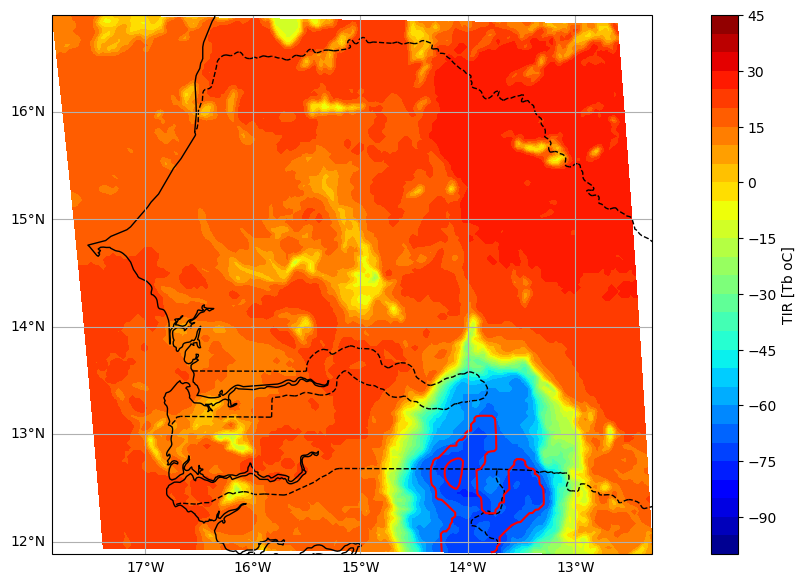

In [10]:
day = 96*19
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, tir[day,:,:], lon, lat, levels=np.arange(-100,50,5), cbar_label='TIR [Tb oC]', cmap='jet')
ax.contour(lon, lat, cores[day,:,:], levels=[-5,1,50], colors='r')

#

In [134]:
# input data
# starting at 
num_frames= 24  # previous 6 hours of images to predict 3 hr later
t0= 3*4 # 
a= 45
b= 48
#cores_t_minus_xhr = cores[0:-2*t0, a:,b:]
#cores_t_0 = cores[t0:-t0, a:,b:]
#tir_t_minus_xhr = tir[0:-2*t0,a:,b:]
#tir_t_0 = tir[t0:-t0, a:,b:]
cores_t_0 = cores[0:-num_frames-t0, :-a,b:]
tir_t_0 = tir[0:-num_frames-t0, :-a,b:]


#target data
cores_t_plus_xhr = cores[t0+num_frames:, :-a,b:]
ind = np.where(cores_t_plus_xhr>0)
cores_t_plus_xhr[ind] = 1
ind_not = np.where(cores_t_plus_xhr<=0)
cores_t_plus_xhr[ind_not] = 0
#print(np.unique(cores_t_plus_xhr))



In [140]:
#cores_t_plus_xhr = cores[t0+num_frames:, a:,b:]
#ind = np.where(cores_t_plus_xhr>0)
#print(np.unique(cores[t0+num_frames:, a:,b:]))
print(np.unique(cores_t_plus_xhr))
#cores_t_plus_xhr.sum()


[0. 1.]


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


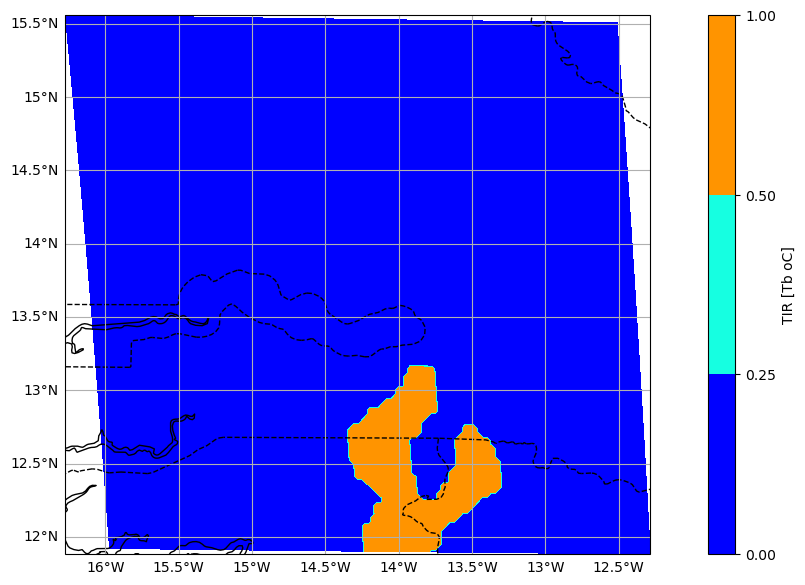

In [139]:
day = 96*19-36
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, cores_t_plus_xhr[day,:,:], lon[:-a,b:], lat[:-a,b:], levels=[0,0.25,0.5,1], cbar_label='TIR [Tb oC]', cmap='jet')
#ax.contour(lon, lat, cores[day,:,:], levels=[-5,1,50], colors='r')

#

In [124]:
print(cores_t_0.shape)
print(cores_t_plus_xhr.shape)
print(len(lat[:-45,1]))
print(len(lat[1,48:]))
print(lat.shape)
173-128
#176-128

(11676, 128, 128)
(11676, 128, 128)
128
128
(173, 176)


45

In [27]:
# save variables 
with open('WA_subdomain_cores.pkl', 'wb') as file: 
          pickle.dump([cores_t_0,tir_t_0,cores_t_plus_xhr], file) 
        

In [5]:
# open a file, where you stored the pickled data
#file = open('WA_subdomain_cores.pkl', 'rb')
#data = pickle.load(file)
#cores_t_0= data[0]
#tir_t_0= data[1]
#cores_t_plus_xhr= data[2]

In [141]:
# Define input shape
#num_frames= 24  # 6 hours
image_height= len(cores_t_plus_xhr[1,:,1]) #lat
image_width= len(cores_t_plus_xhr[1,1,:]) #lon
num_channels= 1 #  core at t0-       tir at t0-x, t0, , cores
#input_shape = (image_height, image_width, num_channels)
#input_shape = (num_frames, image_height, image_width, num_channels)
# Sample data (you should replace this with your own dataset)
#num_samples = len(cores_t_plus_xhr[0,0,:])
#sequence_length = 5



In [142]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, image_height,image_width, num_channels))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=8, #64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=8,#64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=8,#64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)


In [143]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 128, 128,   0         
                             1)]                                 
                                                                 
 conv_lstm2d_6 (ConvLSTM2D)  (None, None, 128, 128, 8  7232      
                             )                                   
                                                                 
 batch_normalization_4 (Batc  (None, None, 128, 128, 8  32       
 hNormalization)             )                                   
                                                                 
 conv_lstm2d_7 (ConvLSTM2D)  (None, None, 128, 128, 8  4640      
                             )                                   
                                                                 
 batch_normalization_5 (Batc  (None, None, 128, 128, 8  32 

In [144]:
num_frames= 24  # hours
batch_size= int(len(cores_t_0[:,0,0])/num_frames)  # days 720 - 96 one day
x_train= np.zeros((batch_size,num_frames,image_height,image_width, num_channels))
y_train= np.zeros((batch_size,num_frames,image_height,image_width, num_channels))
x_val= np.zeros((batch_size,num_frames,image_height,image_width, num_channels))
y_val= np.zeros((batch_size,num_frames,image_height,image_width, num_channels))
                   
    
for i in range(0,batch_size,1):  
    x_train[i,:,:,:,0]= cores_t_0[i*num_frames:(i+1)*num_frames,:,:]
    y_train[i,:,:,:,0]= cores_t_plus_xhr[i*num_frames:(i+1)*num_frames,:,:]

for i in range(0,batch_size,1):  
    x_val[i,:,:,:,0]= cores_t_0[i*num_frames:(i+1)*num_frames,:,:]
    y_val[i,:,:,:,0] = cores_t_plus_xhr[i*num_frames:(i+1)*num_frames,:,:]

           
# normalize input data        
x_train = x_train/np.max(x_train)
x_val = x_val/np.max(x_train)


In [145]:
print(x_train.shape)
#print(np.unique(y_train))
#print(np.unique(y_val))
#batch_size= len(cores_t_0[:,0,0])/num_frames  # days 720 - 96 one day
#print((batch_size+1)*num_frames)
#print(i)
print(batch_size)


(486, 24, 128, 128, 1)
486


In [146]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 3 # 20
batch_size = 24 #50# batch_size#24

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/3
21/21 [==============================] - 518s 25s/step - loss: 0.4917 - val_loss: 0.5943 - lr: 0.0010
Epoch 2/3
21/21 [==============================] - 512s 24s/step - loss: 0.1208 - val_loss: 0.5139 - lr: 0.0010
Epoch 3/3
21/21 [==============================] - 511s 24s/step - loss: 0.0894 - val_loss: 0.4608 - lr: 0.0010


In [ ]:
#example = x_val[np.random.choice(range(len(x_val)), size=1)[0]]
#print(example.shape)

In [159]:
# Select a random example from the validation dataset.
# example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# using x_val for now 
batch_number = 50
frames = x_val[batch_number,:,:,:,:] # 
original_frames = y_val[batch_number,:,:,:,:] # 

# Predict a new set of 10 frames.
for _ in range(2):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)


1/1 [==============================] - 0s 112ms/step


In [160]:
#print(frames.shape)
print(predicted_frame.shape)
#print(original_frames.shape)
print(new_prediction.shape)

(1, 128, 128, 1)
(25, 128, 128, 1)


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


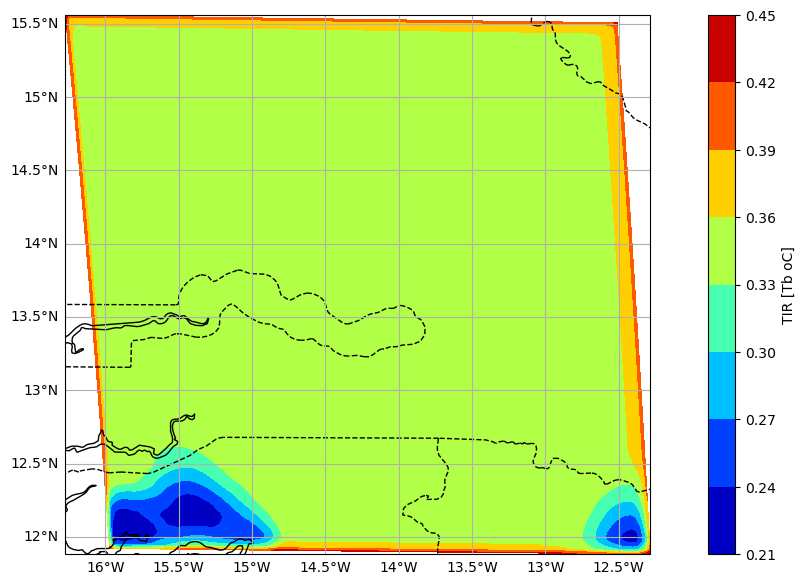

In [161]:
day = 1 #96*19-36
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, np.squeeze(predicted_frame), lon[:-a,b:], lat[:-a,b:], cbar_label='TIR [Tb oC]', cmap='jet')
#ax.contour(lon, lat, cores[day,:,:], levels=[-5,1,50], colors='r')

#


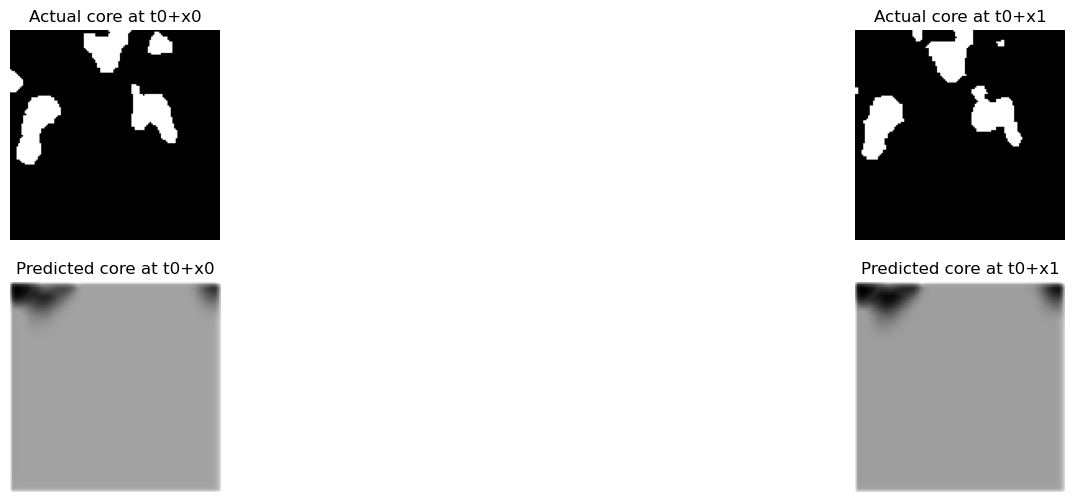

In [163]:
# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 2, figsize=(20, 6))


# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Actual core at t0+x{idx}")
#    ax.set_title(f"Frame {idx + 24}")
    ax.axis("off")

    
# Plot the new frames.
new_frames = frames[24:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Predicted core at t0+x{idx}")
    ax.axis("off")
    

# Plot the new frames.
#data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABkwAAAF0CAYAAABhfBUcAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/OQEPoAAAACXBIWXMAAA9hAAAPYQGoP6dpAABPm0lEQVR4nO3deZQU5dk/7ntgNmRTFgUigitgjKiACpGIIBgxRMUdo0jUF2LUV42icQOMEZP4+jXGLUYQV9xYkrgTxRWMqGjEXUEQwQUUBcGBGZ7fH/6YOM6wNDLTA31d5/Q59tNPVd3dU87UzaerKi+llAIAAAAAACCH1cl2AQAAAAAAANkmMAEAAAAAAHKewAQAAAAAAMh5AhMAAAAAACDnCUwAAAAAAICcJzABAAAAAABynsAEAAAAAADIeQITAAAAAAAg5wlMAAAAAACAnCcwATZZV199deTl5cUuu+yy3uuYN29eDB8+PF5++eUNV9ga9OjRI3r06FEj26otXn/99Rg+fHi8//776zR/ypQpMXz48Fi0aFGVr7/00kux//77R4MGDWLzzTeP/v37x8yZMzdcwetoyZIlccYZZ0SrVq2iuLg4dtttt7jrrrtqvA4AAFgdPdPGYVPsmRYvXhxDhw6NPn36RPPmzSMvLy+GDx9eozUAVEVgAmyyRo8eHRERr732Wvz73/9er3XMmzcvRowYUWMH/7no9ddfjxEjRmR08D9ixIgqD/7ffPPN6NGjRyxfvjzuueeeGD16dLz99tvRvXv3+PTTTzds4WvRv3//uOWWW2LYsGHx0EMPRZcuXeKYY46JO++8s0brAACA1dEzbRw2xZ5p4cKFceONN0ZJSUkccsghNbZdgLURmACbpBdeeCFeeeWVOOiggyIiYtSoUVmuaOOydOnSbJewXi6++OIoKiqK+++/P/r27Rv9+/ePBx54ID799NO44oor1rjs8OHDo23bthukjgcffDAmTZoU1113XQwePDj222+/+Nvf/ha9e/eOc845J8rKyjbIdgAAYH3pmb4fPdP306ZNm/j888/jySefjJEjR26QdQJsCAITYJO06mD/8ssvj27dusVdd91V5QHthx9+GP/zP/8TrVu3jsLCwmjVqlUcfvjh8fHHH8cTTzwRXbp0iYiIQYMGRV5eXoXThFd3KvgJJ5xQ6SByxIgRsddee0WTJk2iUaNGsccee8SoUaMipbTe7/HOO++Mrl27RoMGDaJBgwax2267VWpyRo8eHR07dozi4uJo0qRJHHroofHGG29UqrdBgwbx6quvRp8+faJhw4bRq1eviIhYvnx5XHrppdG+ffsoKiqK5s2bx6BBg9bpm0cvvPBCHH300dG2bduoV69etG3bNo455piYPXt2+ZwxY8bEEUccERER++23X/lnPGbMmCrXOXz48DjnnHMiImLbbbctn//EE09EaWlp3H///XHYYYdFo0aNypdp06ZN7LfffjFhwoS1f6hrkFKKvn37RtOmTWPOnDnl40uXLo0f/vCH0aFDh/jqq68iImLChAnRoEGD8ve2yqBBg2LevHnr/e09AADYUPRM39AzZadnWlUXQG2Tn+0CADa0ZcuWxdixY6NLly6xyy67xC9/+cs46aST4t57742BAweWz/vwww+jS5cusWLFijj//PNj1113jYULF8YjjzwSn3/+eeyxxx5x8803x6BBg+LCCy8s/+bV1ltvnXFN77//fgwePDi22WabiIh47rnn4rTTTosPP/wwLr744ozXd/HFF8fvfve76N+/f/zmN7+Jxo0bx4wZMyocWI8cOTLOP//8OOaYY2LkyJGxcOHCGD58eHTt2jWmTZsWO+64Y/nc5cuXx89//vMYPHhwnHfeeVFaWhorV66Mgw8+OJ5++ukYOnRodOvWLWbPnh3Dhg2LHj16xAsvvBD16tVb43tu165dHH300dGkSZOYP39+XH/99dGlS5d4/fXXo1mzZnHQQQfFZZddFueff35ce+21sccee0RExPbbb1/lOk866aT47LPP4i9/+UuMHz8+WrZsGRERO++8c7z33nuxbNmy2HXXXSstt+uuu8akSZPi66+/juLi4ow/74hvDuhvu+222G233eLII4+Mp59+OgoKCuKUU06JWbNmxb///e+oX79+RETMmDEjOnToEPn5Ff/MrqptxowZ0a1bt/WqAwAAvi890zf0TP9V0z0TQK2VADYxt956a4qIdMMNN6SUUlq8eHFq0KBB6t69e4V5v/zlL1NBQUF6/fXXV7uuadOmpYhIN998c6XX9t1337TvvvtWGh84cGBq06bNatdZVlaWVqxYkS655JLUtGnTtHLlyrWu89tmzpyZ6tatm4499tjVzvn8889TvXr1Ut++fSuMz5kzJxUVFaUBAwZUqDci0ujRoyvMHTt2bIqING7cuArjqz6T6667bo11fldpaWlasmRJql+/fvrzn/9cPn7vvfemiEiTJ09ep/X86U9/ShGRZs2aVWH82WefTRGRxo4dW2mZyy67LEVEmjdvXvnYihUrKjwuuuii1KZNm0rj3/75pJTSM888k/Lz89MZZ5yRRo8enSIi3XTTTRXm7LjjjumAAw6oVMe8efNSRKTLLrtsnd4rAABUBz2Tnum7arpn+rZPP/00RUQaNmzYOr0/gOrkklzAJmfUqFFRr169OProoyMiyi+N9PTTT8c777xTPu+hhx6K/fbbLzp06FDtNT3++OOx//77R+PGjaNu3bpRUFAQF198cSxcuDA++eSTjNY1adKkKCsri1//+ternTN16tRYtmxZnHDCCRXGW7duHT179ozHHnus0jKHHXZYhef3339/bL755tGvX78oLS0tf+y2227RokWLeOKJJ9ZY55IlS+Lcc8+NHXbYIfLz8yM/Pz8aNGgQX331VaVT3DekNZ3W/e3XCgoKKjx+97vfxezZsyuN33LLLRXW8eMf/zh+//vfx1VXXRW/+tWv4he/+EWceOKJ610HAADUND2TnmldXqvungmgNhKYAJuUd999N5566qk46KCDIqUUixYtikWLFsXhhx8eEd9cn3aVTz/9dL1OFc/U888/H3369ImIiL/97W/x7LPPxrRp0+KCCy6IiG9Oh8/Eqmvhrqn2hQsXRkSUn379ba1atSp/fZXNNtuswjVsIyI+/vjjWLRoURQWFlY6IP7oo49iwYIFa6xzwIABcc0118RJJ50UjzzySDz//PMxbdq0aN68ecbveV00bdo0IqLSe4uI+OyzzyIvLy8233zz8rFp06ZVeJx88snRsmXLSuP9+vWrtL5jjz02CgsLo6SkpPz6wN+tZXV1REQ0adJkfd8mAAB8L3qmb+iZKqrpngmgtnIPE2CTMnr06EgpxX333Rf33XdfpddvueWWuPTSS6Nu3brRvHnzmDt37npvq7i4OL744otK4989KL7rrruioKAg7r///grXgp04ceJ6bbd58+YRETF37txo3bp1lXNWHQjPnz+/0mvz5s2LZs2aVRir6htGzZo1i6ZNm8bDDz9c5TYaNmy42hq/+OKLuP/++2PYsGFx3nnnlY+XlJSUhwYb2vbbbx/16tWLV199tdJrr776auywww4VPv/OnTtXmHP//fdHYWFhpfHvKisri2OPPTa22GKLKCoqihNPPDGeffbZKCwsLJ/zox/9KMaOHRulpaUV7mOyqrZddtllvd4jAAB8X3qmb+iZKqrpngmgtnKGCbDJKCsri1tuuSW23377mDx5cqXHb37zm5g/f3489NBDERFx4IEHxuTJk+Ott95a7TqLiooioupvNLVt2zbefvvtKCkpKR9buHBhTJkypcK8vLy8yM/Pj7p165aPLVu2LG677bb1ep99+vSJunXrxvXXX7/aOV27do169erF7bffXmF87ty58fjjj0evXr3Wup2f/exnsXDhwigrK4vOnTtXerRr1261y+bl5UVKqfzzW+Wmm26KsrKyCmNr+oyrsrr5+fn50a9fvxg/fnwsXry4fHzOnDkxefLk6N+//zqtf22GDRsWTz/9dNxxxx1x9913xyuvvFLpG1OHHnpoLFmyJMaNG1dh/JZbbolWrVrFXnvttUFqAQCATOiZ/kvPlN2eCaDWyuYNVAA2pH/+858pItIf/vCHKl//9NNPU1FRUTrkkENSSinNnTs3tWzZMm255ZbpqquuSo899lgaN25cOvnkk9Mbb7yRUkrpq6++SvXq1Us//vGP0+TJk9O0adPShx9+mFL65kZ2EZEOP/zw9Mgjj6Q777wz7bbbbqlNmzYVbmD42GOPlc979NFH09ixY1OnTp3SjjvuWOlGfOtyA8OUUrrooovK1zlu3Lj0r3/9K1199dXp4osvLp+z6qZ9xx13XHrwwQfTbbfdlnbYYYfUuHHj9Pbbb5fPGzhwYKpfv36lbZSWlqYDDzwwNWnSJI0YMSI99NBD6V//+lcaM2ZMGjhwYBo/fvwaa/zJT36SmjRpkv72t7+lSZMmpQsvvDC1bNkybb755mngwIHl82bOnJkiIh1yyCHp6aefTtOmTUsLFixY7XonT56cIiINHjw4TZkyJU2bNi19+eWXKaWU3njjjdSgQYP0k5/8JD344INp/PjxaZdddkmtWrVKn3zyyRrrHTZs2BpvPJlSSo8++miqU6dOhZsRXnHFFSkiKn0evXv3TltssUW68cYb0+OPP55OPvnkFBHp9ttvX+M2AACguuiZ9Ey1qWd68MEH07333lt+Y/gjjjgi3Xvvvenee+9NX3311Rq3A1BdBCbAJuOQQw5JhYWFazzIO/roo1N+fn766KOPUkopffDBB+mXv/xlatGiRSooKEitWrVKRx55ZPr444/Llxk7dmxq3759KigoSBFR4cDvlltuSR06dEjFxcVp5513TnfffXcaOHBgpYPI0aNHp3bt2qWioqK03XbbpZEjR6ZRo0at98F/SindeuutqUuXLqm4uDg1aNAg7b777unmm2+uMOemm25Ku+66ayosLEyNGzdOBx98cHrttdcqzFndwX9KKa1YsSJdccUVqWPHjuXbad++fRo8eHB655131ljf3Llz02GHHZa22GKL1LBhw/TTn/40zZgxI7Vp06bCwX9KKV111VVp2223TXXr1k0RUel9fNdvf/vb1KpVq1SnTp0UEWny5Mnlr73wwgupV69eabPNNkuNGjVKhxxySHr33XfXuL6U1n7wP2/evLTlllumnj17prKysvLxlStXpn79+qXNN9+8ws9y8eLF6fTTT08tWrRIhYWFadddd01jx45dax0AAFBd9Ex6ppRqT8/Upk2bFBFVPr49D6Am5aWUUnWfxQIAAAAAAFCbuYcJAAAAAACQ8wQmAAAAAABAzhOYAAAAAAAAOU9gAgAAAAAA5DyBCQAAAAAAkPMEJgAAAAAAQM4TmAAAAAAAADlPYAJQg/Ly8jaKR48ePWLevHlrfC8lJSXxv//7v+u0vm233Tb69u0bnTt3rrH3AAAAbHyqu09o06ZNpW3usMMO1dIz/ehHP8p6b6dnAshMfrYLAKBmFBYWxh//+MeoW7du+VhJSUmce+65UVZWVmHukiVLYsmSJWtc34gRI+Lqq69ep20feuihceWVV8b7778fxx13XDzzzDOZvwEAAIBa4sknn4zHH388fvGLX2S7FAA2IIEJQI7Iz8+PIUOGRFFRUfnYkiVL4uabb47S0tIKc3/yk5/ETjvttMb1/fOf/1yn7e6zzz5x0UUXRURE27ZtY+LEiXHwwQfHggULYs6cObFs2bIM3wkAAMD6WbFiRXz88cex1VZbfe91zZ8/P8rKyip8KQ2AjZvABCCHNWjQIGbMmFGt27j11ltjiy22KH/etGnT8jNMunfv7mwTAACgxsyfPz8OOeSQuOOOO2K77bb7XuuaPHly/OpXv4oGDRpsoOoAyDaBCQDV5rTTTouWLVuu9vWRI0dGv379YsmSJZXOcgEAAKgOzz33XLz44ovRvHnzuOmmmyrci6Ru3bqx2WabrdN6jj/++A0SltSvXz/q1KkTv/vd72Lx4sXlZ+gDUPMEJgBUmx133DGKi4tX+/o+++wTH3/8cZx88slx66231mBlAABALhswYEDUqVMnSktLY+XKlRHxTVhy0UUXxW9/+9t1Wkd+/ob5Z7VrrrkmBgwYEAUFBet86WMAqkedbBcAwMbl3XffjZNPPjk+/PDDDbK+wsJC1/wFAABqVGlpaSxfvrw8LImIOOuss+LCCy+MwsLCdXrUqVP1P6tl2jP9/ve/j8LCwsjLy9sg7w2A9ecME4AcsXLlypg9e/Zab+a+JrNmzYrevXvH+++/v9a5PXr0iEGDBq33tgAAAGrKwQcfHEcdddRqQ5B1lUnP9O1lfvCDH0RExNdff/29tg/A9+MME4Ac8fXXX8fPf/7zmD59+nqv47zzzlvnA/+ioiI3PwQAADYKf//73+MnP/lJLF++/HutJ5OeaZWysrKYN29ezJs3Lz777LPvtX0Avh+BCUAOeeutt+Lwww+Pt99+O5YtW5bRssuXL8+oeVi+fHksWrSowinuERFLly6NRYsWVXj4FhUAAAAA2eaSXAA5ZubMmbHzzjvH2WefHZdffvk6L3f33XfH3//+93We/8QTT0SzZs3iqquuii233LJ8fNSoUfHYY49VmPvdUAUAAAAAaprABCAHlZWVRVlZWUbLrFy5MlJK6zw/pRRlZWVx2mmnZVoeAABAjVu+fHmcdNJJMWjQoOjZs+d6rSOTngmA2scluQBy1HXXXRe33XabA3oAAICIKC0tjdtvvz3eeuut9Vr+nnvuiX/84x8buCoAapLABCBHLV26NE499dQoLS1d69wlS5ZkdDkuAACAjdUDDzwQ1113XcbLLVu2LEpKSqqhIgBqisAEIIctWbIkLrjggrXOW7p0aUycOLH6CwIAAMiyBx54IP7yl79kuwwAskBgApDDVq5cGe+++262ywAAAKhVvvzyy3jppZeyXQYANUxgAlCD6tSpfb92p02bFgMGDIhFixZV+fq9994bgwcPdq8TAAAgZ8ybNy/uuuuubJcBQA2rff9yB7AJe/jhh2PvvfeOoqKibJdSbu7cuTF27NhYtmxZpdemT58exx9/vMtxAQAAALDJy892AQC5pHfv3tG7d+8YMWJEDB8+PNvlVDBy5Mho0KBBhbH58+fH119/naWKAAAAsuepp56KSy65JC688MJaebUAADa8vOQaKwA1rqSkJC677LK4/PLLY/ny5dkuZ5PkzxsAAGx88vLysl1CBQ0aNIj33nsvttxyyzXOW7BgQXzyySfxq1/9Kp566qkaqu770TMBVCYeB8iCoqKiGDFiRAwbNsw3lQAAAGqpJUuWRN++fePtt99e7Zzp06dH586d44c//OFGE5YAUDX/SgeQRUOHDo1zzz0322UAAACwGi+++GIMGDAgPv3000qvvfXWWzFgwICYPXt2FioDYENzDxOALMrPz48999wz22UAAACwBi+++GL07NkzrrnmmvKxlFIMGDAg5s+fn8XKANiQBCYArLc999wzDj/88Hjvvffir3/9a7bLAQAAqDYzZsyIHj16ZLsMAKqRS3IBZNH7778fZ555ZrbLWG8dO3aMc845J6688sp4/fXXo23bttkuCQAA2Ihts8020aBBg2yXsUHUrVs3Bg8eHK+//nr5Q88EULsJTACy5JVXXokDDjgg3n///WyX8r1tttlm0aFDhygqKsp2KQAAwEZs9uzZMXDgwGyX8b3ttddeMXTo0LjhhhuiQ4cO5Y/DDjss26UBsAYCE4AaVFJSEiUlJTFz5sw4+uij4+233852SQAAAGxgBx98cFx22WWVxk877bTIz3eFfIDaym9ogBrUpEmTiPjm5oDLli3LcjXf39y5c+PTTz+N5s2bR0REt27dIi8vL4qLi8vHqvLUU09FSUlJTZUJAABsJCZNmhQffPBBtsv43t55551YsmRJpcuLffDBB/HLX/4ybrzxxixVBsCa5KWUUraLAMgVeXl5Gc295JJLolGjRhXG33///fh//+//bejS1tuECRPikEMOKX/+n//8Jxo3bhxt2rRZ7TKtW7eOuXPnVmtd/rwBAMDGJ5Oe6dhjj40999yzwtgtt9wSL7300oYua7386le/iuuuu67CWPv27eOtt97KUkUV6ZkAKhOYANSgdTn4v+eee6JTp04REdGmTZuoW7duhddLSkriww8/jIMOOijefPPNaqkzE98NTNbF008/HYceemgsXLiweooKB/8AALAxWlvPNGTIkDjnnHMiImLLLbesdAbH/Pnzo2fPnrWiV9pqq63iP//5T2y55ZblYwcccEBMnz49Pv300/KxNm3aREFBQVx++eWx++67R8Q393I54ogj9EwANcw9TABqkc6dO0fnzp1ju+22i+22265SWBIRUVRUFNttt10MGjQo9t9//yxU+f1179497r777mjVqlW2SwEAADYSTZs2jYMOOqi8X/puWBIR0bJly3jooYeic+fOWaiwoo8//jgOPvjgmDlzZvnYI488EuPHj4+2bduWj02ePDneeeedOOyww8rf23777adnAsgCgQlALdG2bdsYO3ZsbLvttus0f+jQofGLX/yiylBlY9CrV6/Ybrvtsl0GAACwkWjZsmX87Gc/W+u8Vb3VzjvvHIWFhTVQWdXy8vKiRYsW0bBhwwrj++yzT4wfPz4effTRePTRR6NFixZVLq9nAqh5AhOAWqJBgwaxww47ZLTML37xi3VqGGqrLl26ZHSNYgAAIDftsssuse+++67z/B122CGmT58ef/7zn6uxqjVr2bJl3HPPPdG8efNKr+2+++7Ru3fv6N27d9SrV2+169AzAdQsgQnARqxu3brxP//zP1FcXJztUtbL5ZdfHieffHK2ywAAAGq5008/Pa655pqMliksLIyCgoJqqmjtTjvttO+9/WHDhm20VxUA2BgJTABqgZYtW8bYsWPXa9nevXtn9TTz76OwsDB69+6d7TIAAAA2uI35agAAuUpgAlALjBgxInbZZZdslwEAAMAGsM8++0SzZs2yXQYAGRKYAGRZfn5+3HjjjfHZZ59lvOyKFSviyy+/jJRSNVS2dj/72c+ie/fuWdk2AACQG/Lz8ze6s+r79u272pu5A1B7CUwAsqxv374xZcqUaNKkSUbLff3113HWWWdFy5YtY/HixdVU3Zq1bNkymjZt+r3W8YMf/CDatGmzgSoCAAA2NX379o3jjjsu22UAkAMEJgBZVqdOnfW6EeCwYcPimmuuiRUrVlRDVTWna9eu0bNnz2yXAQAA1ELFxcVxyimnRJ066/dPWN27d4899thjA1cFwKZKYAKwkXr44YezXcJazZs3L5YvX57tMgAAgI3Q4MGDY9asWXHAAQes1/KlpaXx9ddfxxZbbLGBK6s5devWjV133XWjfg8AGxOBCUAWFRYWRv/+/dd5/oQJE+LSSy+NSy+9ND755JNqrOz7mzlzZhx22GHxxz/+ca1zf/azn0X9+vVroCoAAGBjMWPGjCgpKVmvZZ944om44IILomPHjvHYY49t4MpqToMGDeLFF1+MQw45JNulAOSE/GwXAJDLioqK4qijjlrrvJRSjBs3LoYMGRILFy6sgcrWzddffx2fffZZpfuvLFy4MPr37x+vvPJKvPzyy3H//ffHyJEjY7/99qtyPYceemg0aNAgvvrqq5ooGwAA2Ag8++yzMXPmzIzveTh16tQ49thjY968edVU2dpdf/31ceCBB8Zuu+221rmLFi2KlStXRkREQUFBNGzYsJqrA2B1nGECUMvNmDEj/va3v8XRRx9dq8KSiIjbb789tt5661iyZEmF8YEDB8Yrr7wSEd+EKv/+97/jkEMOWe3lufLy8qJHjx7VXS4AALCJKysri5///OdZDUsiIj744IPo3bt3PP/882ud26VLl9hyyy1jyy23jOOPP74GqgNgdZxhAlDLjRs3LoYPH57tMqqUUoqSkpI4+eSTIz//v39Spk+fXmnu0qVL4y9/+Uv85je/qXJd119/fZSWlsa4ceOqrV4AAGDTtXLlyrj++uvjyy+/zHYpERGxYMGC+Nvf/hadO3eu9NqKFSvi17/+dZSUlMRHH30UZWVlERHlZ5oAkB0CE4BabOnSpVn/ZtTarFy5Mu666661zistLY2JEyfG8ccfH82bN6/0+hZbbBEdO3YUmAAAABl77rnn4uCDD44vvvhitWe2Z8Ptt98eEydOrPK1BQsWVBr77LPP4tNPP63UM/35z3+Ot99+O5599tnqKBOA/59LcgFkUUlJSdxzzz2rff3NN9+MG2+8sQYrql7PPPNMjB8/PttlAAAAm5jTTjstPvnkk/W+SXx1+frrr2PBggVVPqqyup6pYcOGcc0111R3uQA5T2ACkEXNmjWLLl26ZLuMGrV48eIqTzMvLS1103cAACAjpaWl8cknn0RpaWm2S9lgVtcztWvXLoYMGZKFigByh8AEIItuu+22aNeuXbbLqFFDhw6Nq6++Ol566aUK4zNmzIg//OEPWaoKAADYGP3nP/+JFi1axMsvv5ztUjaYoUOHVnlp5mXLlsXHH3+chYoAcofABCBL8vLyok6dtf8azsvLq4Fqak5KKc4888w49thjY8aMGVFWVlb+AAAAWCUvL2+d+qGUUg1UU3NSSvH73/++0lkms2bNigkTJmSpKoDcIDAByJJTTjkl9tlnnzXO6dixY5x77rk1VFHNevPNN6Nr167RrFmzaNasWey3337ZLgkAAKhF1qVnql+/frRu3bqGKqo5N954YwwePDi+/PLLiPgmRDnqqKOyXBXApi8/2wUA5KJmzZpF//79Iz9/zb+G69atG8XFxTVUVc1bsmRJtksAAABqqeLi4rX2TO3atYsTTzwxhg8fXjNF1ZCVK1fGTTfdFF9//XW0bt06Ukrx0UcfZbssgE2ewAQgC5o2bRo9e/bMdhkAAAC1Un5+fjRu3Hit8+bPnx9ffPFFDVSUHbfffnu2SwDIKQITAAAAAGqV7bffPi666KI1zkkpxW677RaffPJJDVUFwKbOPUwAarGUkpuhAwAAOWdtvdDKlSvjqquu2qTPLgGg5glMAGqx2267Lf7whz9kuwwAAIAa9e6778agQYPi6aefjpRShddKS0vjsssui6FDh0ZJSUmWKgRgU5SXvvtXB4Bqk5eXFxHf3JjwzTffXOPclFK0aNHC6eXryZ83AADY+KzqmVZp2LBhLFiwIAoLC8vHFi1aFM2aNXM2/vekZwKozD1MALJg1qxZ0b59+/jTn/4U/fr1q/T60qVLY+jQobFw4cIsVAcAAFA7fPXVV/GjH/2oQpBSVlYmLAGgWjjDBKAGfffbUkVFRfHHP/4x9t9//9h5553Lx++555446qijarq8TYo/bwAAsPH5bs9E9dEzAVQmMAGoQas7+N9ll12idevW5c/nz58fL7/8cg1VtWny5w0AADY+ApOao2cCqExgAlCDHPzXHH/eAABg46Nnqjl6JoDK6mS7AAAAAAAAgGwTmAAAAAAAADlPYAIAAAAAAOQ8gQkAAAAAAJDzBCYAAAAAAEDOE5gAAAAAAAA5T2ACAAAAAADkPIEJAAAAAACQ8wQmAAAAAABAzhOYAAAAAAAAOU9gAgAAAAAA5DyBCQAAAAAAkPMEJgAAAAAAQM4TmAAAAAAAADlPYAIAAAAAAOQ8gQkAAAAAAJDzBCYAAAAAAEDOE5gAAAAAAAA5T2ACAAAAAADkPIEJAAAAAACQ8wQmAAAAAABAzhOYAAAAAAAAOU9gAgAAAAAA5DyBCQAAAAAAkPMEJgAAAAAAQM4TmAAAAAAAADlPYAIAAAAAAOQ8gQkAAAAAAJDzBCYAAAAAAEDOE5jAJmzMmDGRl5dX/sjPz4+tt946Bg0aFB9++GGN1NC2bds44YQTyp8/8cQTkZeXF0888URG65kyZUoMHz48Fi1atEHri4g44YQTom3btht8vWRfVfvbgw8+GMOHD89aTZlu/84774yrrrpqta/fddddsdtuu0VxcXG0atUqzjjjjFiyZMn3LzRDM2fOjP79+8fmm28eDRo0iN69e8dLL71U43UAAGRK37Ru9E2bLn1TzXjttdfilFNOia5du0b9+vXX6/9xoPoJTCAH3HzzzTF16tSYNGlSnHzyyTF27Njo3r17fPXVVzVeyx577BFTp06NPfbYI6PlpkyZEiNGjKiWA382XVXtbw8++GCMGDEiazVluv01Hfjfcccdccwxx0SXLl3ioYceimHDhsWYMWOif//+G6jadfPpp59G9+7d4+23347Ro0fHPffcE19//XX06NEj3nrrrRqtBQBgfembyFX6pprxwgsvxMSJE6NJkybRq1evGt02sO4EJpADdtlll9h7771jv/32i2HDhsXQoUNj1qxZMXHixNUus3Tp0mqppVGjRrH33ntHo0aNqmX9tV1KabWPr776ao2vV/dj5cqVsXTp0nWef/PNN0dExLRp0zZYDcOGDYuIb/4Bfn2Wj4gYNmxY+X9vyvtbWVlZnHPOOdGnT5/429/+Fvvtt18MHjw4rrvuupg0aVI89NBDa1y+R48eFb7F+H386U9/ik8//TQeeOCB6N+/f/Tt2zceeOCBKCoqiosvvniDbAMAoLrpm2qHtR3z65s2XN+0yqa8v9Wmvum4446LefPmxQMPPBDHH3/8BlknsOEJTCAH7b333hERMXv27Ij45tTqBg0axKuvvhp9+vSJhg0bln/bYfny5XHppZdG+/bto6ioKJo3bx6DBg2KTz/9tMI6V6xYEUOHDo0WLVrEZpttFvvss088//zzlba9ulPL//3vf0e/fv2iadOmUVxcHNtvv32cccYZERExfPjwOOeccyIiYtttty0/Vf7b67j77rvLT2tt0KBBHHDAATF9+vRK2x8zZky0a9cuioqKokOHDnHrrbdm9Nndeeed0bVr12jQoEE0aNAgdttttxg1alSFOaNHj46OHTtGcXFxNGnSJA499NB44403KszZEJ95VVat97XXXotevXpF/fr1o3nz5nHqqadWauby8vLi1FNPjRtuuCE6dOgQRUVFccstt0RExDPPPBO9evWKhg0bxmabbRbdunWLBx54oMptfv755zFo0KBo0qRJ1K9fP/r16xczZ86sMGfSpElx8MEHx9Zbbx3FxcWxww47xODBg2PBggVVrvODDz6I/v37R6NGjaJx48bxi1/8otL779GjR/To0WONn8d397cTTjghrr322vL3v+rx/vvvR69evaJ9+/blDcQqKaXYYYcd4qCDDlrjtu6+++7o06dPtGzZMurVqxcdOnSI8847r8I3Ete0/ar06NEjHnjggZg9e3aF+RERzz33XMyfPz8GDRpUYZkjjjgiGjRoEBMmTFhjvWuzYMGCaN26dXTr1i1WrFhRPv76669H/fr147jjjisfmzBhQvTs2TPatGlTPtaoUaPo379//POf/4zS0tLvVQsAQDbom/RNEfomfdOaZdI31anjn2FhY+D/VMhB7777bkRENG/evHxs+fLl8fOf/zx69uwZf//732PEiBGxcuXKOPjgg+Pyyy+PAQMGxAMPPBCXX355TJo0KXr06BHLli0rX/7kk0+OK664Io4//vj4+9//Hocddlj0798/Pv/887XW88gjj0T37t1jzpw5ceWVV8ZDDz0UF154YXz88ccREXHSSSfFaaedFhER48ePj6lTp1Y4Xfiyyy6LY445Jnbeeee455574rbbbovFixdH9+7d4/XXXy/fzpgxY2LQoEHRoUOHGDduXFx44YXxu9/9Lh5//PF1+twuvvjiOPbYY6NVq1YxZsyYmDBhQgwcOLC8gYqIGDlyZJx44onxwx/+MMaPHx9//vOf4z//+U907do13nnnnQrr+76f+eqsWLEi+vbtG7169YqJEyfGqaeeGn/961/jqKOOqjR34sSJcf3118fFF19c/nN48skno2fPnvHFF1/EqFGjYuzYsdGwYcPo169f3H333ZXWceKJJ0adOnXKT4F+/vnno0ePHhUuA/Dee+9F165d4/rrr49HH300Lr744vj3v/8d++yzT4WDylUOPfTQ2GGHHeK+++6L4cOHx8SJE+OAAw6ocm4mLrroojj88MMjIsr3o6lTp0bLli3jf//3f+Ott96Kxx57rMIyDz30ULz33nvx61//eo3rfuedd6Jv374xatSoePjhh+OMM86Ie+65J/r167dO26/KddddFz/+8Y+jRYsWFeZHRMyYMSMiInbdddcKyxQUFET79u3LX19fzZo1i7vuuiumTZsW5557bkR88w3KI444IrbZZpu44YYbIiJi2bJl8d5771WqY1Vty5Ytq9QIAgBsDPRN+qZV9E36ptVZ174J2IgkYJN18803p4hIzz33XFqxYkVavHhxuv/++1Pz5s1Tw4YN00cffZRSSmngwIEpItLo0aMrLD927NgUEWncuHEVxqdNm5YiIl133XUppZTeeOONFBHpzDPPrDDvjjvuSBGRBg4cWD42efLkFBFp8uTJ5WPbb7992n777dOyZctW+17+9Kc/pYhIs2bNqjA+Z86clJ+fn0477bQK44sXL04tWrRIRx55ZEoppbKystSqVau0xx57pJUrV5bPe//991NBQUFq06bNaredUkozZ85MdevWTccee+xq53z++eepXr16qW/fvpVqLCoqSgMGDCgf+76f+eqsWu+f//znCuO///3vU0SkZ555pnwsIlLjxo3TZ599VmHu3nvvnbbccsu0ePHi8rHS0tK0yy67pK233rr881u1fx166KEVln/22WdTRKRLL720yhpXrlyZVqxYkWbPnp0iIv39738vf23YsGFr3Jduv/328rF999037bvvvhXmRUQaNmxY+fOq9rdf//rXqao/f2VlZWm77bZLBx98cIXxAw88MG2//fYV9pu1WfUen3zyyRQR6ZVXXlnr9lfnoIMOqnL/XPUznT9/fqXX+vTpk3baaadK9Xz78ZOf/CQdf/zxlca/6w9/+EOKiDRhwoQ0cODAVK9evfSf//yn/PUPP/wwRUQaOXJkpWXvvPPOFBFpypQp6/x+AQBqmr5J37SKvmly+Zi+acP2Td917733VvrMgdrBGSaQA/bee+8oKCiIhg0bxs9+9rNo0aJFPPTQQ7HVVltVmHfYYYdVeH7//ffH5ptvHv369YvS0tLyx2677RYtWrQoP1138uTJERFx7LHHVlj+yCOPjPz8/DXW9vbbb8d7770XJ554YhQXF2f83h555JEoLS2N448/vkKNxcXFse+++5bX+NZbb8W8efNiwIAB5afmRkS0adMmunXrttbtTJo0KcrKytb4bZmpU6fGsmXLKl3ftHXr1tGzZ89K38CJWP/PfG2++7MYMGBARPz3Z7VKz549Y4sttih//tVXX8W///3vOPzww6NBgwbl43Xr1o3jjjsu5s6dW+km3t/dVrdu3aJNmzYVtvXJJ5/EkCFDonXr1pGfnx8FBQXll2/67mn3Va1z1b703fo3pDp16sSpp54a999/f8yZMycivvmG18MPPxynnHJKhf2mKjNnzowBAwZEixYtom7dulFQUBD77rtvRFT9HjeU1dX17fEnn3wyCgoKKjyeeuqpuPXWWyuNf/c093POOScOOuigOOaYY+KWW26Jv/zlL/GjH/1onetY22sAALWFvknfpG9aO33T9+ubgNpvzX+RgU3CrbfeGh06dIj8/PzYaqutqjyNdbPNNqt0g7ePP/44Fi1aFIWFhVWud9V1VBcuXBgRES1atKjwen5+fjRt2nSNta26vurWW2+9bm/mO1adft6lS5cqX191jdDV1bhqbHXXQs2kzlXbqOrzbdWqVUyaNKnC2Pf5zNekqs991fteVeMq3631888/j5TSat9DVetY3We6at7KlSujT58+MW/evLjoooviRz/6UdSvXz9WrlwZe++9d5Wny69uX/rutje0X/7yl3HxxRfHDTfcEJdddllce+21Ua9evfjlL3+5xuWWLFkS3bt3j+Li4rj00ktjp512is0226z8msLrckmATK36GS9cuLBSE//ZZ59FkyZNyp936tQppk2bVmHO4MGDo1WrVhVu9hjx35/zKnl5eXHCCSfEAw88EC1atKhwDd6IiC222CLy8vKq/Nl89tlnEREVagEAqK30TfomfdO60Tdl3jcBGw+BCeSADh06ROfOndc4p6pvWzRr1iyaNm0aDz/8cJXLNGzYMCL+ewDy0UcfxQ9+8IPy10tLS9d6oLbqesBz585d47zVadasWURE3HfffRVuOP1d367xu6oa+65v19m6des1bmP+/PmVXps3b155rat8n898TVZ97t8++F/1Hr/bEHy3hi222CLq1Kmz2vewqsZvW91nusMOO0TEN9eMfeWVV2LMmDExcODA8jmrrgldldXtS2trJL+vxo0bx8CBA+Omm26Ks88+O26++eYYMGBAbL755mtc7vHHH4958+bFE088Uf7tqIiocD3iDW3Vt5VeffXV2HnnncvHS0tL480334xjjjmmfKxhw4aVfgc0bNgwmjZtutbfDfPnz49f//rXsdtuu8Vrr70WZ599dlx99dXlr9erVy922GGHePXVVyst++qrr0a9evViu+22W6/3CABQk/RN+iZ907rRN1W2tr4J2Hi4JBewWj/72c9i4cKFUVZWFp07d670aNeuXURE9OjRIyIi7rjjjgrL33PPPVFaWrrGbey0006x/fbbx+jRo6OkpGS184qKiiIiKn3j5IADDoj8/Px47733qqxx1UFNu3btomXLljF27NhIKZUvP3v27JgyZcpaP4s+ffpE3bp14/rrr1/tnK5du0a9evXi9ttvrzA+d+7cePzxx6NXr15r3c66fuZr892fxZ133hkR//1ZrU79+vVjr732ivHjx1f4rFeuXBm33357bL311rHTTjutcVtTpkyJ2bNnl29rVXOx6me4yl//+td1rn/VvrS2+tfF6valVU4//fRYsGBBHH744bFo0aI49dRT17rOTN7j2rZf1fyq5u61117RsmXLGDNmTIXx++67L5YsWRL9+/dfp/WvSVlZWRxzzDGRl5cXDz30UIwcOTL+8pe/xPjx4yvMO/TQQ+Pxxx+PDz74oHxs8eLFMX78+Pj5z3++1ktMAABszPRN/6Vv0jetSa73TcDGwb9gAKt19NFHxx133BF9+/aN//3f/40999wzCgoKYu7cuTF58uQ4+OCD49BDD40OHTrEL37xi7jqqquioKAg9t9//5gxY0ZcccUVlU6drsq1114b/fr1i7333jvOPPPM2GabbWLOnDnxyCOPlB8ArvpWyJ///OcYOHBgFBQURLt27aJt27ZxySWXxAUXXBAzZ86Mn/70p7HFFlvExx9/HM8//3zUr18/RowYEXXq1Inf/e53cdJJJ8Whhx4aJ598cixatCiGDx9e5anR39W2bds4//zz43e/+10sW7YsjjnmmGjcuHG8/vrrsWDBghgxYkRsvvnmcdFFF8X5558fxx9/fBxzzDGxcOHCGDFiRBQXF1c6hff7fOZrUlhYGP/3f/8XS5YsiS5dusSUKVPi0ksvjQMPPDD22WeftdYwcuTI6N27d+y3335x9tlnR2FhYVx33XUxY8aMGDt2bKVvV73wwgtx0kknxRFHHBEffPBBXHDBBfGDH/wgTjnllIiIaN++fWy//fZx3nnnRUopmjRpEv/85z8rnWr/bePHj4/8/Pzo3bt3vPbaa3HRRRdFx44d48gjj1xr/Wuzal/6wx/+EAceeGDUrVs3dt111/LT+Xfaaaf46U9/Gg899FDss88+0bFjx7Wus1u3brHFFlvEkCFDYtiwYVFQUBB33HFHvPLKKxlvv6r548ePj+uvvz46deoUderUic6dO0fdunXjj3/8Yxx33HExePDgOOaYY+Kdd96JoUOHRu/eveOnP/3p+n5E5YYNGxZPP/10PProo9GiRYv4zW9+E08++WSceOKJsfvuu8e2224bERFnn3123HbbbXHQQQfFJZdcEkVFRXH55ZfH119/HcOHD//edQAA1Gb6pv/SN+mb1iTX+6alS5fGgw8+GBERzz33XER8c9+UBQsWRP369ePAAw/83rUAG0A27zgPVK+bb745RUSaNm3aGucNHDgw1a9fv8rXVqxYka644orUsWPHVFxcnBo0aJDat2+fBg8enN55553yeSUlJek3v/lN2nLLLVNxcXHae++909SpU1ObNm3SwIEDy+dNnjw5RUSaPHlyhe1MnTo1HXjggalx48apqKgobb/99unMM8+sMOe3v/1tatWqVapTp06ldUycODHtt99+qVGjRqmoqCi1adMmHX744elf//pXhXXcdNNNaccdd0yFhYVpp512SqNHj04DBw5Mbdq0WeNntMqtt96aunTpUv5Z7L777unmm2+utI1dd901FRYWpsaNG6eDDz44vfbaaxXmbIjPvCqr1vuf//wn9ejRI9WrVy81adIk/epXv0pLliypMDci0q9//esq1/P000+nnj17pvr166d69eqlvffeO/3zn/+sMGfV/vXoo4+m4447Lm2++eapXr16qW/fvpXqfP3111Pv3r1Tw4YN0xZbbJGOOOKINGfOnBQRadiwYeXzhg0bliIivfjii6lfv36pQYMGqWHDhumYY45JH3/8cYV17rvvvmnfffet9J6+vb6q9reSkpJ00kknpebNm6e8vLwUEWnWrFkV1jNmzJgUEemuu+6q8vOpypQpU1LXrl3TZpttlpo3b55OOumk9NJLL6WIqLCPrMv2v+2zzz5Lhx9+eNp8883L53/bnXfeWb6/tWjRIp1++ulp8eLFa6133333rfD/5nc9+uijqU6dOhU+z5RSWrhwYdpmm21Sly5dUklJSfn4u+++mw455JDUqFGjtNlmm6VevXqlF198ca11AABkm75J36Rv0jetzobsm2bNmpUiosrHuv6/BVS/vJS+dY4lABu1E044ofzUYtbfYYcdFs8991y8//77UVBQkO1yAACADUjftGHom4BNkUtyAUBElJSUxEsvvRTPP/98TJgwIa688koH/QAAAN+ibwI2dQITAIiI+fPnR7du3aJRo0YxePDgOO2007JdEgAAQK2ibwI2dS7JBQAAAAAA5Lw62S4AAAAAAAAg2wQmAAAAAABAzhOYAAAAAAAAOU9gAgAAAAAA5Lz8bBcAkEvy8vKyXULOSClluwQAACBDeqaao2cCqMwZJgAAAAAAQM4TmAAAAAAAADlPYAIAAAAAAOQ8gQkAAAAAAJDzBCYAAAAAAEDOE5gAAAAAAAA5T2ACAAAAAADkPIEJAAAAAACQ8wQmAAAAAABAzhOYAAAAAAAAOU9gAgAAAAAA5DyBCQAAAAAAkPMEJgAAAAAAQM4TmAAAAAAAADlPYAIAAAAAAOQ8gQkAAAAAAJDzBCYAAAAAAEDOE5gAAAAAAAA5T2ACAAAAAADkPIEJAAAAAACQ8wQmAAAAAABAzhOYAAAAAAAAOU9gAgAAAAAA5DyBCQAAAAAAkPMEJgAAAAAAQM4TmAAAAAAAADlPYAIAAAAAAOQ8gQkAAAAAAJDzBCYAAAAAAEDOE5gAAAAAAAA5T2ACAAAAAADkPIEJAAAAAACQ8wQmAAAAAABAzhOYAAAAAAAAOU9gAgAAAAAA5DyBCQAAAAAAkPMEJgAAAAAAQM4TmAAAAAAAADlPYAIAAAAAAOQ8gQkAAAAAAJDzBCYAAAAAAEDOE5gAAAAAAAA5T2ACAAAAAADkPIEJAAAAAACQ8wQmAAAAAABAzhOYAAAAAAAAOU9gAgAAAAAA5DyBCQAAAAAAkPMEJgAAAAAAQM4TmAAAAAAAADlPYAIAAAAAAOQ8gQkAAAAAAJDzBCYAAAAAAEDOE5gAAAAAAAA5T2ACAAAAAADkPIEJAAAAAACQ8wQmAAAAAABAzhOYAAAAAAAAOU9gAgAAAAAA5DyBCQAAAAAAkPMEJgAAAAAAQM4TmAAAAAAAADlPYAIAAAAAAOQ8gQkAAAAAAJDzBCYAAAAAAEDOE5gAAAAAAAA5T2ACAAAAAADkPIEJAAAAAACQ8wQmAAAAAABAzhOYAAAAAAAAOU9gAgAAAAAA5DyBCQAAAAAAkPMEJgAAAAAAQM4TmAAAAAAAADlPYAIAAAAAAOQ8gQkAAAAAAJDzBCYAAAAAAEDOE5gAAAAAAAA5T2ACAAAAAADkPIEJAAAAAACQ8wQmAAAAAABAzhOYAAAAAAAAOU9gAgAAAAAA5DyBCQAAAAAAkPMEJgAAAAAAQM4TmAAAAAAAADlPYAIAAAAAAOQ8gQkAAAAAAJDzBCYAAAAAAEDOE5gAAAAAAAA5Ly+llLJdBAAAAAAAQDY5wwQAAAAAAMh5AhMAAAAAACDnCUwAAAAAAICcJzABAAAAAABynsAEAAAAAADIeQITAAAAAAAg5wlMAAAAAACAnCcwAQAAAAAAcp7ABAAAAAAAyHkCEwAAAAAAIOcJTAAAAAAAgJwnMAEAAAAAAHJexoHJU089Ff369YtWrVpFXl5eTJw4ca3LPPnkk9GpU6coLi6O7bbbLm644Yb1qRUAAKDW0zMBAMDGKePA5KuvvoqOHTvGNddcs07zZ82aFX379o3u3bvH9OnT4/zzz4/TTz89xo0bl3GxAAAAtZ2eCQAANk55KaW03gvn5cWECRPikEMOWe2cc889N/7xj3/EG2+8UT42ZMiQeOWVV2Lq1Knru2kAAIBaT88EAAAbj2q/h8nUqVOjT58+FcYOOOCAeOGFF2LFihXVvXkAAIBaTc8EAAC1Q351b+Cjjz6KrbbaqsLYVlttFaWlpbFgwYJo2bJlpWVKSkqipKSk/PnKlSvjs88+i6ZNm0ZeXl51lwwAAFmVUorFixdHq1atok6dav+OE1mmZwIAgMxVR99U7YFJRFQ6YF91FbDVHciPHDkyRowYUe11AQBAbfbBBx/E1ltvne0yqAF6JgAAWD8bsm+q9sCkRYsW8dFHH1UY++STTyI/Pz+aNm1a5TK//e1v46yzzip//sUXX8Q222wTH3zwQTRq1Kha6wUAgGz78ssvo3Xr1tGwYcNsl0IN0DMBAEDmqqNvqvbApGvXrvHPf/6zwtijjz4anTt3joKCgiqXKSoqiqKiokrjjRo1cvAPAEDOcGml3KBnAgCA9bch+6aML+y1ZMmSePnll+Pll1+OiIhZs2bFyy+/HHPmzImIb77pdPzxx5fPHzJkSMyePTvOOuuseOONN2L06NExatSoOPvsszfMOwAAAKhF9EwAALBxyvgMkxdeeCH222+/8uerTgMfOHBgjBkzJubPn1/eCEREbLvttvHggw/GmWeeGddee220atUqrr766jjssMM2QPkAAAC1i54JAAA2Tnlp1d0Ea7Evv/wyGjduHF988YXTywEA2OQ5/iVT9hkAAHJNdRwDZ3xJLgAAAAAAgE2NwAQAAAAAAMh5AhMAAAAAACDnCUwAAAAAAICcJzABAAAAAABynsAEAAAAAADIeQITAAAAAAAg5wlMAAAAAACAnCcwAQAAAAAAcp7ABAAAAAAAyHkCEwAAAAAAIOcJTAAAAAAAgJwnMAEAAAAAAHKewAQAAAAAAMh5AhMAAAAAACDnCUwAAAAAAICcJzABAAAAAABynsAEAAAAAADIeQITAAAAAAAg5wlMAAAAAACAnCcwAQAAAAAAcp7ABAAAAAAAyHkCEwAAAAAAIOcJTAAAAAAAgJwnMAEAAAAAAHKewAQAAAAAAMh5AhMAAAAAACDnCUwAAAAAAICcJzABAAAAAABynsAEAAAAAADIeQITAAAAAAAg5wlMAAAAAACAnCcwAQAAAAAAcp7ABAAAAAAAyHkCEwAAAAAAIOetV2By3XXXxbbbbhvFxcXRqVOnePrpp1c794knnoi8vLxKjzfffHO9iwYAAKjN9EwAALDxyTgwufvuu+OMM86ICy64IKZPnx7du3ePAw88MObMmbPG5d56662YP39++WPHHXdc76IBAABqKz0TAABsnDIOTK688so48cQT46STTooOHTrEVVddFa1bt47rr79+jcttueWW0aJFi/JH3bp117toAACA2krPBAAAG6eMApPly5fHiy++GH369Kkw3qdPn5gyZcoal919992jZcuW0atXr5g8efIa55aUlMSXX35Z4QEAAFDb6ZkAAGDjlVFgsmDBgigrK4utttqqwvhWW20VH330UZXLtGzZMm688cYYN25cjB8/Ptq1axe9evWKp556arXbGTlyZDRu3Lj80bp160zKBAAAyAo9EwAAbLzy12ehvLy8Cs9TSpXGVmnXrl20a9eu/HnXrl3jgw8+iCuuuCJ+8pOfVLnMb3/72zjrrLPKn3/55ZcaAAAAYKOhZwIAgI1PRmeYNGvWLOrWrVvpm1GffPJJpW9Qrcnee+8d77zzzmpfLyoqikaNGlV4AAAA1HZ6JgAA2HhlFJgUFhZGp06dYtKkSRXGJ02aFN26dVvn9UyfPj1atmyZyaYBAABqPT0TAABsvDK+JNdZZ50Vxx13XHTu3Dm6du0aN954Y8yZMyeGDBkSEd+cGv7hhx/GrbfeGhERV111VbRt2zZ++MMfxvLly+P222+PcePGxbhx4zbsOwEAAKgF9EwAALBxyjgwOeqoo2LhwoVxySWXxPz582OXXXaJBx98MNq0aRMREfPnz485c+aUz1++fHmcffbZ8eGHH0a9evXihz/8YTzwwAPRt2/fDfcuAAAAagk9EwAAbJzyUkop20WszZdffhmNGzeOL774wrV5AQDY5Dn+JVP2GQAAck11HANndA8TAAAAAACATZHABAAAAAAAyHkCEwAAAAAAIOcJTAAAAAAAgJwnMAEAAAAAAHKewAQAAAAAAMh5AhMAAAAAACDnCUwAAAAAAICcJzABAAAAAABynsAEAAAAAADIeQITAAAAAAAg5wlMAAAAAACAnCcwAQAAAAAAcp7ABAAAAAAAyHkCEwAAAAAAIOcJTAAAAAAAgJwnMAEAAAAAAHKewAQAAAAAAMh5AhMAAAAAACDnCUwAAAAAAICcJzABAAAAAABynsAEAAAAAADIeQITAAAAAAAg5wlMAAAAAACAnCcwAQAAAAAAcp7ABAAAAAAAyHkCEwAAAAAAIOcJTAAAAAAAgJwnMAEAAAAAAHKewAQAAAAAAMh5AhMAAAAAACDnCUwAAAAAAICcJzABAAAAAABynsAEAAAAAADIeesVmFx33XWx7bbbRnFxcXTq1CmefvrpNc5/8skno1OnTlFcXBzbbbdd3HDDDetVLAAAwMZAzwQAABufjAOTu+++O84444y44IILYvr06dG9e/c48MADY86cOVXOnzVrVvTt2ze6d+8e06dPj/PPPz9OP/30GDdu3PcuHgAAoLbRMwEAwMYpL6WUMllgr732ij322COuv/768rEOHTrEIYccEiNHjqw0/9xzz41//OMf8cYbb5SPDRkyJF555ZWYOnXqOm3zyy+/jMaNG8cXX3wRjRo1yqRcAADY6Dj+3bjpmQAAoPpVxzFwfiaTly9fHi+++GKcd955Fcb79OkTU6ZMqXKZqVOnRp8+fSqMHXDAATFq1KhYsWJFFBQUVFqmpKQkSkpKyp9/8cUXEfHNBwAAAJu6Vce9GX63iVpAzwQAADWjOvqmjAKTBQsWRFlZWWy11VYVxrfaaqv46KOPqlzmo48+qnJ+aWlpLFiwIFq2bFlpmZEjR8aIESMqjbdu3TqTcgEAYKO2cOHCaNy4cbbLIAN6JgAAqFkbsm/KKDBZJS8vr8LzlFKlsbXNr2p8ld/+9rdx1llnlT9ftGhRtGnTJubMmaNhZJ18+eWX0bp16/jggw9ckoB1Yp8hU/YZMmF/IVNffPFFbLPNNtGkSZNsl8J60jNR2/nbRKbsM2TKPkOm7DNkqjr6powCk2bNmkXdunUrfTPqk08+qfSNqFVatGhR5fz8/Pxo2rRplcsUFRVFUVFRpfHGjRv7n4WMNGrUyD5DRuwzZMo+QybsL2SqTp062S6BDOmZ2Nj420Sm7DNkyj5DpuwzZGpD9k0ZramwsDA6deoUkyZNqjA+adKk6NatW5XLdO3atdL8Rx99NDp37lzltXgBAAA2VnomAADYeGUcvZx11llx0003xejRo+ONN96IM888M+bMmRNDhgyJiG9ODT/++OPL5w8ZMiRmz54dZ511VrzxxhsxevToGDVqVJx99tkb7l0AAADUEnomAADYOGV8D5OjjjoqFi5cGJdccknMnz8/dtlll3jwwQejTZs2ERExf/78mDNnTvn8bbfdNh588ME488wz49prr41WrVrF1VdfHYcddtg6b7OoqCiGDRtW5SnnUBX7DJmyz5Ap+wyZsL+QKfvMxk3PxMbAPkOm7DNkyj5DpuwzZKo69pm8tOpuggAAAAAAADnKXSQBAAAAAICcJzABAAAAAABynsAEAAAAAADIeQITAAAAAAAg59WawOS6666LbbfdNoqLi6NTp07x9NNPr3H+k08+GZ06dYri4uLYbrvt4oYbbqihSqktMtlnxo8fH717947mzZtHo0aNomvXrvHII4/UYLVkW6a/Y1Z59tlnIz8/P3bbbbfqLZBaJ9N9pqSkJC644IJo06ZNFBUVxfbbbx+jR4+uoWqpDTLdZ+64447o2LFjbLbZZtGyZcsYNGhQLFy4sIaqJdueeuqp6NevX7Rq1Sry8vJi4sSJa13G8S96JjKlZyJT+iYypW8iU/om1lW2eqZaEZjcfffdccYZZ8QFF1wQ06dPj+7du8eBBx4Yc+bMqXL+rFmzom/fvtG9e/eYPn16nH/++XH66afHuHHjarhysiXTfeapp56K3r17x4MPPhgvvvhi7LffftGvX7+YPn16DVdONmS6v6zyxRdfxPHHHx+9evWqoUqpLdZnnznyyCPjsccei1GjRsVbb70VY8eOjfbt29dg1WRTpvvMM888E8cff3yceOKJ8dprr8W9994b06ZNi5NOOqmGKydbvvrqq+jYsWNcc8016zTf8S96JjKlZyJT+iYypW8iU/omMpG1ninVAnvuuWcaMmRIhbH27dun8847r8r5Q4cOTe3bt68wNnjw4LT33ntXW43ULpnuM1XZeeed04gRIzZ0adRC67u/HHXUUenCCy9Mw4YNSx07dqzGCqltMt1nHnroodS4ceO0cOHCmiiPWijTfeZPf/pT2m677SqMXX311WnrrbeuthqpvSIiTZgwYY1zHP+iZyJTeiYypW8iU/omMqVvYn3VZM+U9TNMli9fHi+++GL06dOnwnifPn1iypQpVS4zderUSvMPOOCAeOGFF2LFihXVViu1w/rsM9+1cuXKWLx4cTRp0qQ6SqQWWd/95eabb4733nsvhg0bVt0lUsuszz7zj3/8Izp37hx//OMf4wc/+EHstNNOcfbZZ8eyZctqomSybH32mW7dusXcuXPjwQcfjJRSfPzxx3HffffFQQcdVBMlsxFy/Jvb9ExkSs9EpvRNZErfRKb0TVS3DXX8m7+hC8vUggULoqysLLbaaqsK41tttVV89NFHVS7z0UcfVTm/tLQ0FixYEC1btqy2esm+9dlnvuv//u//4quvvoojjzyyOkqkFlmf/eWdd96J8847L55++unIz8/6r0lq2PrsMzNnzoxnnnkmiouLY8KECbFgwYI45ZRT4rPPPnM93hywPvtMt27d4o477oijjjoqvv766ygtLY2f//zn8Ze//KUmSmYj5Pg3t+mZyJSeiUzpm8iUvolM6Zuobhvq+DfrZ5iskpeXV+F5SqnS2NrmVzXOpivTfWaVsWPHxvDhw+Puu++OLbfcsrrKo5ZZ1/2lrKwsBgwYECNGjIiddtqppsqjFsrkd8zKlSsjLy8v7rjjjthzzz2jb9++ceWVV8aYMWN8WyqHZLLPvP7663H66afHxRdfHC+++GI8/PDDMWvWrBgyZEhNlMpGyvEveiYypWciU/omMqVvIlP6JqrThjj+zfpXAJo1axZ169atlCR+8sknlRKhVVq0aFHl/Pz8/GjatGm11UrtsD77zCp33313nHjiiXHvvffG/vvvX51lUktkur8sXrw4XnjhhZg+fXqceuqpEfHNQV1KKfLz8+PRRx+Nnj171kjtZMf6/I5p2bJl/OAHP4jGjRuXj3Xo0CFSSjF37tzYcccdq7Vmsmt99pmRI0fGj3/84zjnnHMiImLXXXeN+vXrR/fu3ePSSy/1zW8qcfyb2/RMZErPRKb0TWRK30Sm9E1Utw11/Jv1M0wKCwujU6dOMWnSpArjkyZNim7dulW5TNeuXSvNf/TRR6Nz585RUFBQbbVSO6zPPhPxzbekTjjhhLjzzjtd6zCHZLq/NGrUKF599dV4+eWXyx9DhgyJdu3axcsvvxx77bVXTZVOlqzP75gf//jHMW/evFiyZEn52Ntvvx116tSJrbfeulrrJfvWZ59ZunRp1KlT8TCsbt26EfHfb8DAtzn+zW16JjKlZyJT+iYypW8iU/omqtsGO/7N6Bbx1eSuu+5KBQUFadSoUen1119PZ5xxRqpfv356//33U0opnXfeeem4444rnz9z5sy02WabpTPPPDO9/vrradSoUamgoCDdd9992XoL1LBM95k777wz5efnp2uvvTbNnz+//LFo0aJsvQVqUKb7y3cNGzYsdezYsYaqpTbIdJ9ZvHhx2nrrrdPhhx+eXnvttfTkk0+mHXfcMZ100knZegvUsEz3mZtvvjnl5+en6667Lr333nvpmWeeSZ07d0577rlntt4CNWzx4sVp+vTpafr06Ski0pVXXpmmT5+eZs+enVJy/EtleiYypWciU/omMqVvIlP6JjKRrZ6pVgQmKaV07bXXpjZt2qTCwsK0xx57pCeffLL8tYEDB6Z99923wvwnnngi7b777qmwsDC1bds2XX/99TVcMdmWyT6z7777poio9Bg4cGDNF05WZPo75tsc+OemTPeZN954I+2///6pXr16aeutt05nnXVWWrp0aQ1XTTZlus9cffXVaeedd0716tVLLVu2TMcee2yaO3duDVdNtkyePHmNxyaOf6mKnolM6ZnIlL6JTOmbyJS+iXWVrZ4pLyXnLwEAAAAAALkt6/cwAQAAAAAAyDaBCQAAAAAAkPMEJgAAAAAAQM4TmAAAAAAAADlPYAIAAAAAAOQ8gQkAAAAAAJDzBCYAAAAAAEDOE5gAAAAAAAA5T2ACAAAAAADkPIEJAAAAAACQ8wQmAAAAAABAzhOYAAAAAAAAOe//A8A2yGwaAs84AAAAAElFTkSuQmCCnew_frames_prob = frames[24:, ...]
#for idx, ax in enumerate(axes[1]):
 #   plot_image = np.squeeze(new_frames_prob[idx])
 #   ind = np.where(plot_image>0.5)
 #   plot_image[ind]=1
 #   ind_not = np.where(plot_image<=0.5)
 #   plot_image[ind_not]=0
 #   ax.imshow(plot_image, cmap="gray")
 #   ax.set_title(f"Predicted core probability at t0+x{idx}")
 #   ax.axis("off")

# Display the figure.
plt.show()

In [ ]:
#num_frames= 24  # hours
#batch_size= len(cores_t_0[:,0,0])/num_frames  # days 720 - 96 one day
#num_of_batches = round(len(cores_t_0[:,0,0])/batch_size)
#x_train= np.zeros((num_of_batches,num_frames,image_height,image_width, num_channels))
#y_train= np.zeros((num_of_batches,num_frames,image_height,image_width, num_channels))
#x_val= np.zeros((num_of_batches,num_frames,image_height,image_width, num_channels))
#y_val= np.zeros((num_of_batches,num_frames,image_height,image_width, num_channels))
                 
#for i in range(0,num_of_batches,1): #i=batch number
    #x_batch= cores_t_0[i:i+batch_size,:,:]
    #y_batch= cores_t_plus_xhr[i:i+batch_size,:,:]
    #for j in range(0, num_of_batches, batch_size,num_frames):
     #   f=1    
 #   x_train[i,:,:,:,0]= cores_t_0[i*num_frames:(i+1)*num_frames,:,:]
  #  y_train[i,:,:,:,0] = cores_t_plus_xhr[i*num_frames:(i+1)*num_frames,:,:]
        
#x_train = x_train/np.max(x_train)
#        
#x_val = 
#y_val[i+500] = create_shifted_frames(val_dataset)
#for i in range(0,num_of_batches,1): #i=batch number
    #x_batch= cores_t_0[i:i+batch_size,:,:]
    #y_batch= cores_t_plus_xhr[i:i+batch_size,:,:]
    #for j in range(0, num_of_batches, batch_size,num_frames):
     #   f=1    
 #   x_val[i,:,:,:,0]= cores_t_0[i*num_frames:(i+1)*num_frames,:,:]
  #  y_val[i,:,:,:,0] = cores_t_plus_xhr[i*num_frames:(i+1)*num_frames,:,:]
    
#x = data[:, 0 : data.shape[1] - 1, :, :]
#y = data[:, 1 : data.shape[1], :, :]
#batch_size (# of samples for training), num_frames (frames per video), width, height, channels) - 
#Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
#Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)